# Descrição inicial: <br> 
**Contexto** <br>
* *Criar um modelo de classificação usando uma regressão logística.*

**Dados** <br>
* *O dataset contém 500 mil registos referentes a campanhas enviadas para vários clientes.*
    * *Cada linha corresponde a um envio para um cliente em determinada data. Existem diversas variáveis relativas a caracteristicas ecónomicas, socio profissionais e comportamentais que se pretende que sejam úteis para explicar o evento. O sucesso está registado na variável iReacção. Os dados já se entram pré-tratados.

**Objectivo** <br>
* *O objectivo deste trabalho é identificar um conjunto de características que sejam explicativas da taxa de resposta dos clientes as campanhas. Pretende-se utilizar num este score para optimização de campanhas, custos e gestão operacional, este projecto propõem-se a identificar os clientes mais propensos a responder.*

**Nota** <br>
* *Este projecto corresponde a um iniciativa real e com dados reais anonimizados. Este projecto entrou em produção em 2022.*

___

# Contents <a class="anchor" id="Contents"></a>
* [Teoria](#chapter1)
* [Importar Bibliotecas](#chapter2)
* [Importar Dados](#chapter3)
    * [Funções de Apoio](#chapter4)  
* [Análise Exploratória](#chapter5)
    * [Classificação dos Dados](#chapter6)
    * [Tratamento de Dados](#chapter7)
* [Seleção de Variáveis e Modelação](#chapter8)
* [Aplicação do Modelo](#chapter9)
* [Resumo](#chapter10)

___
# Teoria<a class="anchor" id="chapter1"></a>

**Modelos de Classificação:** <br>

 Um modelo de classificação atribui a cada entidade **observação** a classificação mais apropriada. Este processo baseia-se nos dados históricos préviamente classificados, daí o nome supervisionado. A esta classificação atribuimos o nome de **target** durante a fase de treino. O processo classificação dos dados pode ocorrer naturalmente ou ser definido pelo utilizar de acordo com conjunto de permissas. A existência desta caracteristicas na base de dados de estudo é essencial para que possámos treinar o modelo e guiá-lo a identificar o conjunto de características explicativas **padrões** que ajudam ao modelo a **explicar** o evento que pretendemos classificar e por consequência a conseguir gerar classificações para novos dados de entrada com base nos padrões identificados.

Para mais sobre o tema podem por exemplo consultar: <br>

https://scikit-learn.org/stable/ <br>
https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html <br>

___
# Importar Bibliotecas<a class="anchor" id="chapter2"></a>

In [1]:
#Importar Packages 

#manipulação
import pandas as pd
import numpy as np

#visualização
import matplotlib.pyplot as plt
import seaborn as sns

#modelação
import statsmodels.api as sm
from xgboost  import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance

#configurar pandas
pd.set_option('display.max_rows', None)        #mostra todas as linhas do dataframe
pd.set_option('display.max_columns', None)     #mostra todas as colunas do dataframe

___
# Importar Dados<a class="anchor" id="chapter3"></a>

In [2]:
#Ler dataframe, fazer uma cópia - boa prática que assegura que sempre que precisarem de comparar o dataframe original podem fazer sem ter de realizar novas importações
dataset = pd.read_csv(r'\\UF38PU04.cm-cic.fr\serv_dadosemodelos\Modelos\06.TeamUp\07.JEEC\ModelodeClassificacao\01.Dataframes\Logistic_Regression_exercicio_1.csv', delimiter = ';')

#observar os nossos dados importados 
dataset.head()

,ROW_ID,DtCampanha,iClienteInativo,Rendimentos,Max_Idade,Max_NumDependentes,TipologiaProfissao_T1,TipologiaProfissao_T2,iProfissaoQualificada_Lar,Max_AntiguidadeProfissional,NumParticipacoes,PrestMes,TaxaEsforco,CRC_Divida_Total,CRC_Potencial,CRC_Divida_Regular,CRC_Divida_Vencida,CRC_Divida_Habitacao,CRC_Divida_Consumo,CRC_Divida_Auto,CRC_Divida_Cartao,CRC_Divida_Descobertos,CRC_Divida_ContasCorrentes,CRC_Potencial_Cartao,CRC_Potencial_Descobertos,CRC_Potencial_ContasCorrentes,CRC_Divida_Revolving,CRC_Potencial_Revolving,TxUtil_Revolving,iCreditoHabitacao,iCreditoConsumo,iCreditoAuto,iCreditoRevolving,NProspetos_24M,NProspetosAceites_24M,NProspetosRecusados_24M,Antiguidade_UltPedido,iClienteAuto,iClientePCD,iClienteRevolving,iClienteConso,iReacao
0,1,20210615,0,676.95,36,0.0,Profissao Qualificada,NaN,1,53.0,8.0,582.0,0.859739,76873.0,5602.0,76873.0,0.0,0.0,34900.0,30347.0,94.0,0.0,0.0,5402.0,200.0,1000.0,94.0,6602.0,0.014038,0,1,1,1,0,0,0,147.0,0,1,0,1,0
1,2,20210301,1,1800.00,40,0.0,Profissao Nao Qualificada,NaN,0,217.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,880.0,0,0,0,0,0
2,3,20210601,0,5247.18,70,0.0,Indeterminado,Indeterminado,0,NaN,6.0,228.0,0.043452,19997.0,10593.0,19997.0,0.0,0.0,1902.0,17694.0,401.0,0.0,0.0,8493.0,2100.0,0.0,401.0,10593.0,0.036474,0,1,1,1,0,0,0,1574.0,1,0,0,0,0
3,4,20210726,0,711.89,43,0.0,Profissao Nao Qualificada,NaN,0,270.0,3.0,0.0,0.000000,4022.0,5645.0,4022.0,0.0,0.0,0.0,0.0,1754.0,0.0,2268.0,4413.0,0.0,1232.0,4022.0,5645.0,0.416054,0,0,0,1,0,0,0,504.0,0,0,1,0,0
4,5,20220112,0,897.00,38,0.0,Profissao Nao Qualificada,NaN,0,226.0,2.0,295.0,0.328874,6530.0,7327.0,6530.0,0.0,0.0,0.0,6137.0,393.0,0.0,0.0,7327.0,0.0,0.0,393.0,7327.0,0.050906,0,0,1,1,0,0,0,78.0,1,1,0,0,0


In [3]:
#copiar dados e comparar volumes
df = dataset.copy()

print('Número de Colunas Original',len(dataset.columns))
print('Número de Colunas Cópia',len(df.columns))
print('Número de Registos Original',len(dataset))
print('Número de Registos Cópia',len(df))

Número de Colunas Original 42
Número de Colunas Cópia 42
Número de Registos Original 500000
Número de Registos Cópia 500000


___
# Importar Funções de Apoio <a class="anchor" id="chapter4"></a>


In [4]:
#valores a missing e outliers
def generate_report(df, feature_list, numerical_list, numeric_list):
    # Replace -1 with NaN for numeric columns
    for column in numerical_list:
        df[column] = df[column].replace(-1, np.nan)

    total_records = len(df)
    report = pd.DataFrame({'Features': feature_list})
    
    # Consider -1 and 'NA' as null values for numeric and categorical columns respectively
    nulls = df[feature_list].apply(lambda x: sum(x.isnull() | (x == 'NA')))
    report['Volumes'] = df[feature_list].count().values
    report['Nulls'] = nulls.values
    report['Null %'] = (nulls.values / total_records) * 100

    outliers_count = []
    outliers_percentage = []
    for column in feature_list:
        if column in numeric_list:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outlier_count = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
            outliers_count.append(outlier_count)
            outlier_percentage = (outlier_count / total_records) * 100
            outliers_percentage.append(outlier_percentage)
        else:
            # Calculate counts and percentages for categorical columns
            value_counts = df[column].value_counts(normalize=True)
            less_than_1_percent = value_counts[value_counts < 0.03]
            
            if not less_than_1_percent.empty:
                # Count records in classes with less than 3% representation
                records_less_than_1_percent = (df[column].isin(less_than_1_percent.index)).sum()
            else:
                records_less_than_1_percent = 0
            
            outliers_count.append(records_less_than_1_percent)
            outliers_percentage.append((records_less_than_1_percent / total_records) * 100)
            
    report['Outliers'] = outliers_count
    report['Outliers %'] = outliers_percentage

    return report

In [5]:
#Funções Continuas - Analise Univariável
def kbins_univariate(data, variables, k=10):
    for variable in variables:
        aux = data.groupby(pd.qcut(data[variable], q=k, duplicates='drop'))['Target'].\
                       agg(['count', 'mean'])

        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.bar(x=aux.index.astype('str'), height=aux['count'], alpha=0.5, edgecolor='k')
        ax.tick_params(axis='x', labelrotation=90)

        ax_twinx = ax.twinx()
        ax_twinx.plot(aux.index.astype('str'), aux['mean'], c='darkred')
        plt.title(f'Univariate Analysis for {variable}')
        plt.show()

        print(aux)
        
#Funções Categorical - Univariável        
def categorical_univariate(data, variables, min_freq=1000):
    for variable in variables:
        aux = data.groupby(data[variable])['Target'].agg(['count', 'mean'])
        aux = aux[aux['count'] >= min_freq].copy()

        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.bar(x=aux.index.astype('str'), height=aux['count'], alpha=0.5, edgecolor='k')
        ax.tick_params(axis='x', labelrotation=90)

        ax_twinx = ax.twinx()
        ax_twinx.plot(aux.index.astype('str'), aux['mean'], c='darkred')

        plt.title(f'Univariate Categorical Analysis - {variable}')
        plt.show()   
        
#tratamento de missing através de alimentação de Valores predefinido -- assumimos o valor -9999 considerando que não temos valores negativos nas variaveis que observamos
def impute_nan_create_category(DataFrame,ColName):
     DataFrame[ColName] = np.where(DataFrame[ColName].isnull(),"NA",DataFrame[ColName]) ## Call function to create new category for variables
     
def impute_nan_create_numeric(DataFrame,ColName):
     DataFrame[ColName] = np.where(DataFrame[ColName].isnull(),0,DataFrame[ColName])   ## Call function to create new category for variables 
     
class PowerTransform(BaseEstimator, TransformerMixin):

    def __init__(self):
        return None

    def fit(self, X):
        return self

    def transform(self, X):
        X_ = X.copy()
        X_/=1000
        return X_
    
numeric_transformer = Pipeline(
    steps = [('power', PowerTransform())
    ]
)

def get_column_names(ct, full_varlist):
    
    transformed_var = []
    for transformer in ct.transformers:
        transformed_var.extend(transformer[2])

    out_vars = transformed_var + [var for var in full_varlist if var not in transformed_var] 
    return out_vars  

___
# Análise Exploratória Dados<a class="anchor" id="chapter5"></a>

> Tratamento de Dados e do Dataframe, limpeza de colunas e dados desnecessários

> Análise das colunas olhando para o nome e valores das mesmas. <br>
> Nas colunas temos a coluna `ROW_ID` que corresponde ao nosso identificador único por registo e a nossa target `iReacao`, ou seja variável alvo, que iremos renomear, e a variável de apoio `DtCampanha` devemos inspecionar o tipo de dados e valores.  <br>
> As restantes variáveis são variáveis explicativas que devemos estudas para missing ou nan value, outliers, entre outros.  <br> 

In [6]:
#vamos alterar o nome da variavel target para Target - todas as restantes seguiam uma determinada nomenclatura que devemos manter
df.rename(columns={'iReacao':'Target'}, inplace=True)

#e verificar colunas no dataframe
df.columns

Index(['ROW_ID', 'DtCampanha', 'iClienteInativo', 'Rendimentos', 'Max_Idade',
       'Max_NumDependentes', 'TipologiaProfissao_T1', 'TipologiaProfissao_T2',
       'iProfissaoQualificada_Lar', 'Max_AntiguidadeProfissional',
       'NumParticipacoes', 'PrestMes', 'TaxaEsforco', 'CRC_Divida_Total',
       'CRC_Potencial', 'CRC_Divida_Regular', 'CRC_Divida_Vencida',
       'CRC_Divida_Habitacao', 'CRC_Divida_Consumo', 'CRC_Divida_Auto',
       'CRC_Divida_Cartao', 'CRC_Divida_Descobertos',
       'CRC_Divida_ContasCorrentes', 'CRC_Potencial_Cartao',
       'CRC_Potencial_Descobertos', 'CRC_Potencial_ContasCorrentes',
       'CRC_Divida_Revolving', 'CRC_Potencial_Revolving', 'TxUtil_Revolving',
       'iCreditoHabitacao', 'iCreditoConsumo', 'iCreditoAuto',
       'iCreditoRevolving', 'NProspetos_24M', 'NProspetosAceites_24M',
       'NProspetosRecusados_24M', 'Antiguidade_UltPedido', 'iClienteAuto',
       'iClientePCD', 'iClienteRevolving', 'iClienteConso', 'Target'],
      dtype='object'

In [7]:
#avaliar DtCampanha como é esperar esta variavel deve ter repetições visto que de cada vez que enviamos em cada data a mesma campanhas a vários clientes
print(f'Temos {len(df.DtCampanha)} envios, mas {len(df.DtCampanha.unique())} datas de campanha. O que corresponde a  {len(df.DtCampanha)/len(df.DtCampanha.unique())} por cada data de campanha.')
#avaliar Id como é esperar esta variavel não têm repetições cada id é único e representa um envio para uma campanha.
print(f'Temos {len(df.ROW_ID.unique())} ids e {len(df.ROW_ID)} envios. O que, como esperado, representa que o Id é um identificador único de cada envios.')

Temos 500000 envios, mas 86 datas de campanha. O que corresponde a  5813.953488372093 por cada data de campanha.
Temos 500000 ids e 500000 envios. O que, como esperado, representa que o Id é um identificador único de cada envios.


> Avaliar a Target podemos usar uma simplificação que nos permite:

1. Avaliar para missing values
2. Avaliar o tipo de valores na target
3. Avaliar a prevalência do evento a prever

> Assim, não temos missing values, temos dois valores na target, a target é binária [0,1] sendo que queremos prever os eventos [1] e por fim sabemos que a pervalência de eventos é de 1.2289% ou seja este é o valor no nosso dataset que reage a campanhas.

In [8]:
df['Target'].value_counts(normalize=True)

Target
0    0.988002
1    0.011998
Name: proportion, dtype: float64

___
## Classificação das variáveis explicativas <a class="anchor" id="chapter6"></a>

   * permite apoio ao processo de análises exploratórias.

In [9]:
#Separamos as variáveis por Tipo
categoricas = ['TipologiaProfissao_T1',
               'TipologiaProfissao_T2',
               ]

binarias = ['iClienteInativo',
            'iProfissaoQualificada_Lar',
            'iCreditoHabitacao',
            'iCreditoConsumo',
            'iCreditoAuto',
            'iCreditoRevolving',
            'iClienteAuto',
            'iClientePCD',
            'iClienteRevolving',
            'iClienteConso',
            ]

continuas = ['Rendimentos',
             'Max_Idade',
             'Max_NumDependentes',
             'Max_AntiguidadeProfissional',
             'NumParticipacoes',
             'PrestMes',
             'TaxaEsforco',
             'CRC_Divida_Total',
             'CRC_Potencial',
             'CRC_Divida_Regular',
             'CRC_Divida_Vencida',
             'CRC_Divida_Habitacao',
             'CRC_Divida_Consumo',
             'CRC_Divida_Auto',
             'CRC_Divida_Cartao',
             'CRC_Divida_Descobertos',
             'CRC_Divida_ContasCorrentes',
             'CRC_Potencial_Cartao',
             'CRC_Potencial_Descobertos',
             'CRC_Potencial_ContasCorrentes',
             'CRC_Divida_Revolving',
             'CRC_Potencial_Revolving',
             'TxUtil_Revolving',
             'NProspetos_24M',
             'NProspetosAceites_24M',
             'NProspetosRecusados_24M',
             'Antiguidade_UltPedido',                       
             ]

cat          = binarias+categoricas
numericas    = continuas+binarias
explicativas = continuas+binarias+categoricas


___
## Análises <a class="anchor" id="chapter7"></a>

   * Análise de Outliers e Missing Values;
   * Análise Univariável Categóricas e Contínuas
   * Tranformações de Variáveis
   

> Outliers e missings:

> - Há uma % idêntica de missing em várias variáveis, analise especializada mostra que é uma caracteristica. Exemplo: Nem todos os contratos têm 2º titular, nem todos os cliente têm informação de CRC sobre um determinados produto
> - Outliers - verificamos que algumas variáveis têm % de outliers relevantes teremos de abordar este tratamento posterioremente.

> Assim os missing não são erros de inputação, mas caracteriticas em si da variaveis e são em si próprias informação.
> Os outliers devem ser tratados.

In [10]:
# toda a população
df_var_explicativas = df[explicativas].copy()

report_table = generate_report(df_var_explicativas.copy(), explicativas, numericas, continuas)
# exportar os resultados para um excel para analise posterior
report_table.to_excel(r'\\UF38PU04.cm-cic.fr\serv_dadosemodelos\Modelos\06.TeamUp\07.JEEC\ModelodeClassificacao\02.Outputs\report_table.xlsx', index=False)

> Variáveis Contínuas <br>
> Olhando para os resultados do agrupamento das variaveis continuas em Decis vs Risco Médio que conclusões podemos tirar:

* Há relações lineares entre a Target e a variável explicativa? 
* Há evidências de capacidade discriminativa das variáveis?
* Há necessidade de criar classes para evitar pontos de inversão?

> Entre outros estes são alguns pontos que devemos considerar ao observar estas variáveis.
> A visualização em decis foi um opção, podemos visualizar as variáveis nosem agrupar em decis, altearado no código o `k=10`

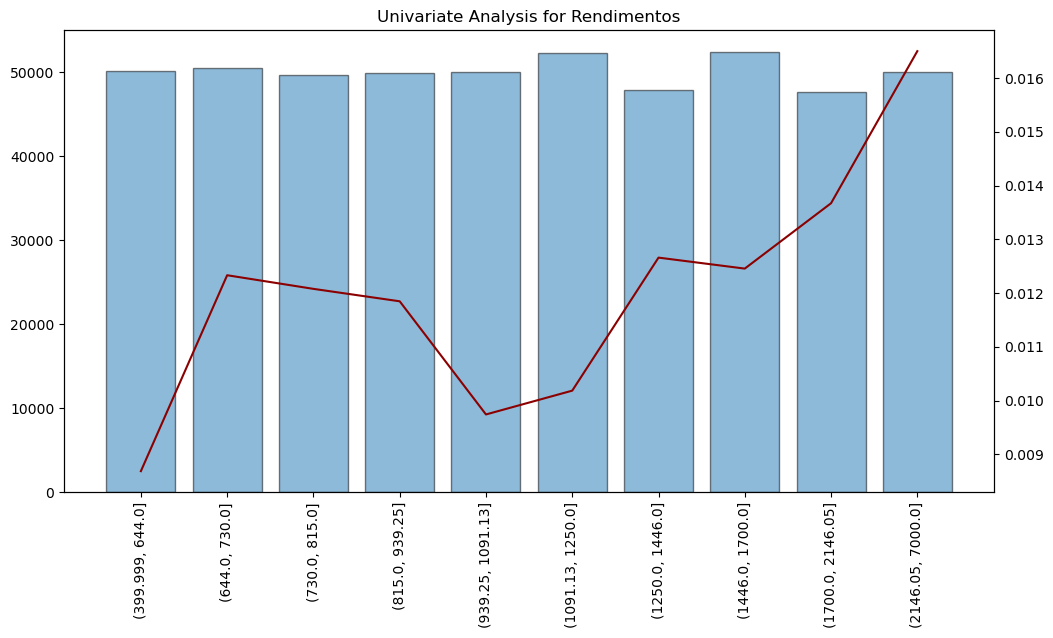

                   count      mean
Rendimentos                       
(399.999, 644.0]   50080  0.008686
(644.0, 730.0]     50441  0.012331
(730.0, 815.0]     49596  0.012078
(815.0, 939.25]    49889  0.011846
(939.25, 1091.13]  49995  0.009741
(1091.13, 1250.0]  52239  0.010184
(1250.0, 1446.0]   47792  0.012659
(1446.0, 1700.0]   52350  0.012455
(1700.0, 2146.05]  47619  0.013671
(2146.05, 7000.0]  49999  0.016500


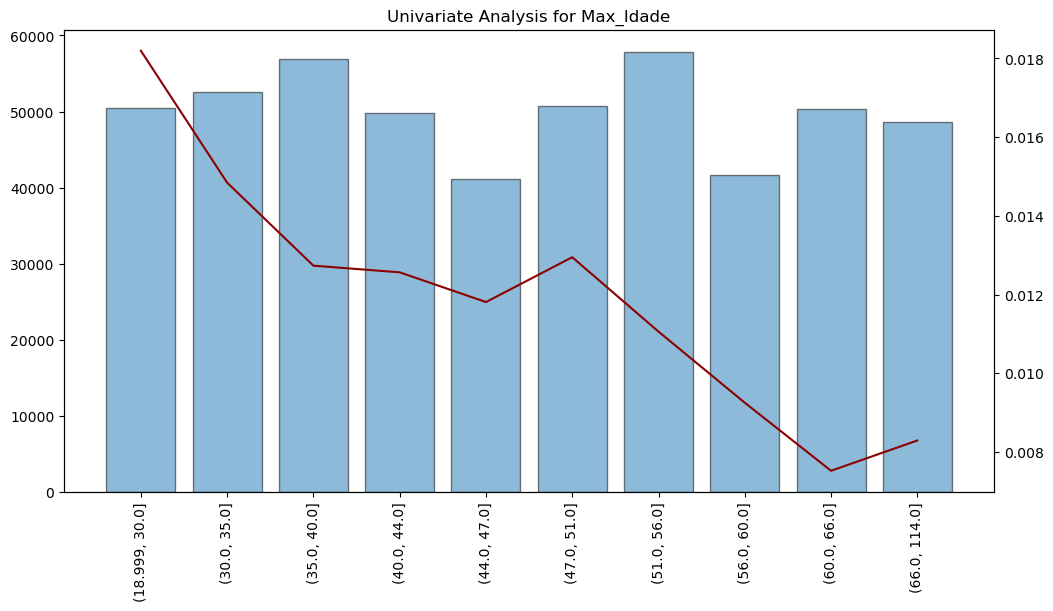

                count      mean
Max_Idade                      
(18.999, 30.0]  50398  0.018195
(30.0, 35.0]    52609  0.014845
(35.0, 40.0]    56841  0.012737
(40.0, 44.0]    49809  0.012568
(44.0, 47.0]    41140  0.011813
(47.0, 51.0]    50728  0.012951
(51.0, 56.0]    57853  0.011063
(56.0, 60.0]    41701  0.009256
(60.0, 66.0]    50348  0.007528
(66.0, 114.0]   48573  0.008297


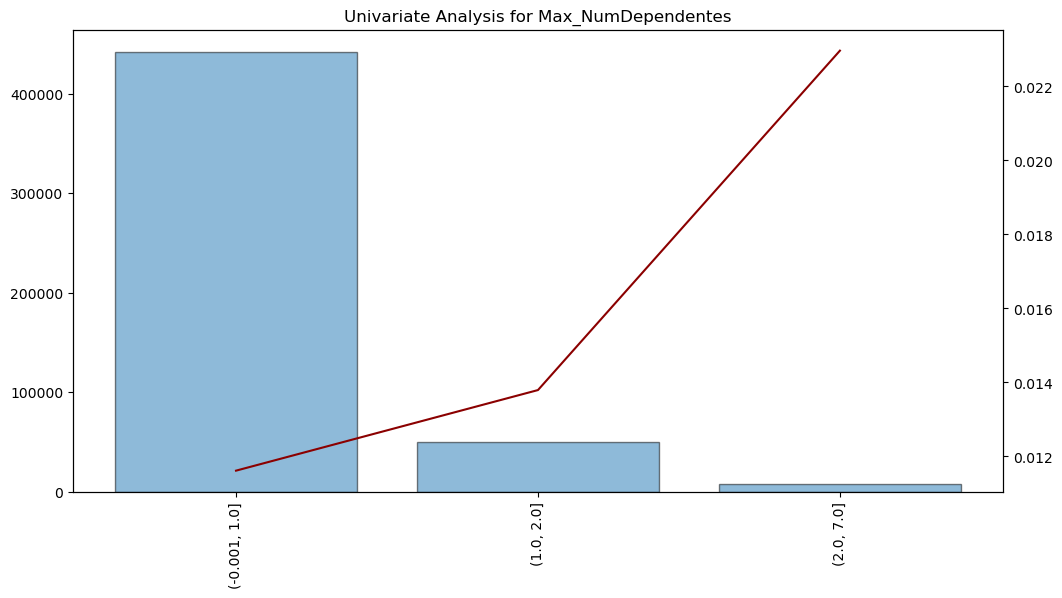

                     count      mean
Max_NumDependentes                  
(-0.001, 1.0]       442449  0.011617
(1.0, 2.0]           49801  0.013795
(2.0, 7.0]            7489  0.022967


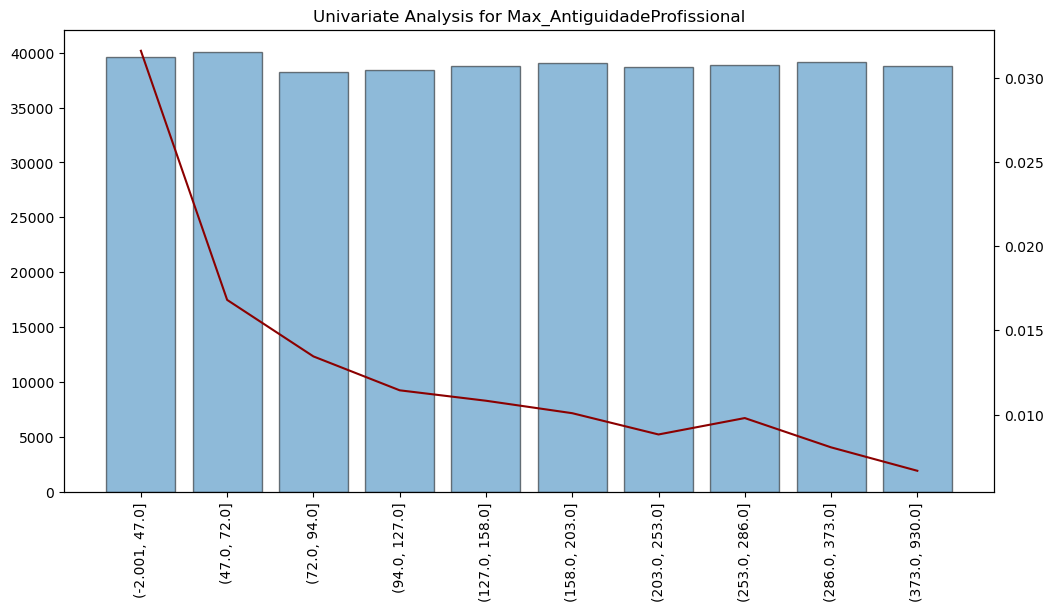

                             count      mean
Max_AntiguidadeProfissional                 
(-2.001, 47.0]               39593  0.031622
(47.0, 72.0]                 40086  0.016814
(72.0, 94.0]                 38277  0.013455
(94.0, 127.0]                38462  0.011440
(127.0, 158.0]               38816  0.010820
(158.0, 203.0]               39088  0.010080
(203.0, 253.0]               38683  0.008815
(253.0, 286.0]               38916  0.009790
(286.0, 373.0]               39131  0.008050
(373.0, 930.0]               38757  0.006657


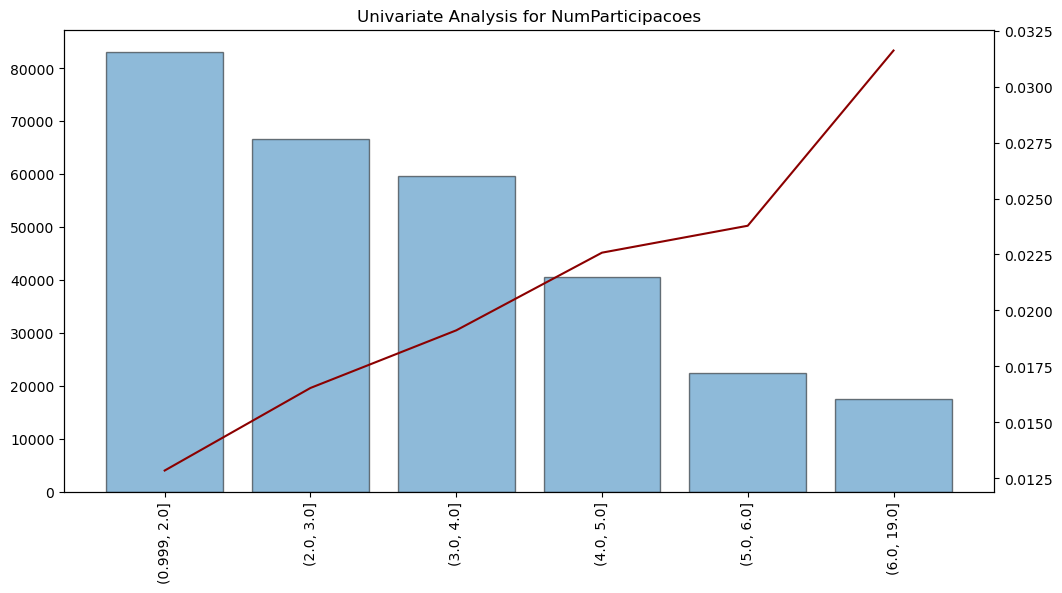

                  count      mean
NumParticipacoes                 
(0.999, 2.0]      83153  0.012844
(2.0, 3.0]        66591  0.016534
(3.0, 4.0]        59555  0.019108
(4.0, 5.0]        40477  0.022581
(5.0, 6.0]        22452  0.023784
(6.0, 19.0]       17555  0.031615


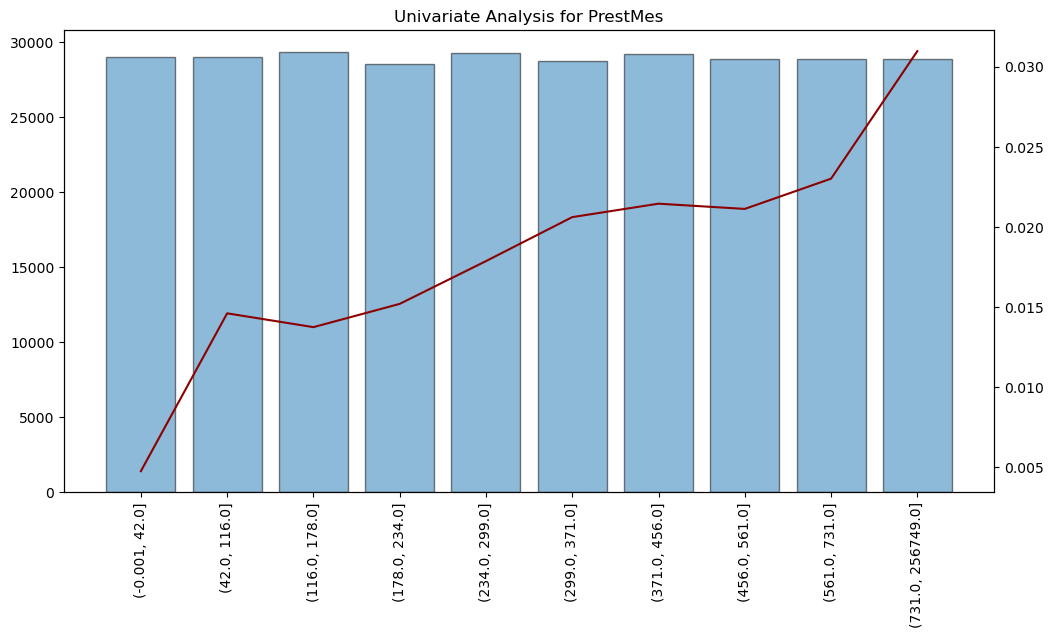

                   count      mean
PrestMes                          
(-0.001, 42.0]     29023  0.004755
(42.0, 116.0]      29027  0.014607
(116.0, 178.0]     29320  0.013745
(178.0, 234.0]     28559  0.015197
(234.0, 299.0]     29272  0.017867
(299.0, 371.0]     28720  0.020613
(371.0, 456.0]     29228  0.021452
(456.0, 561.0]     28875  0.021126
(561.0, 731.0]     28896  0.023014
(731.0, 256749.0]  28863  0.030974


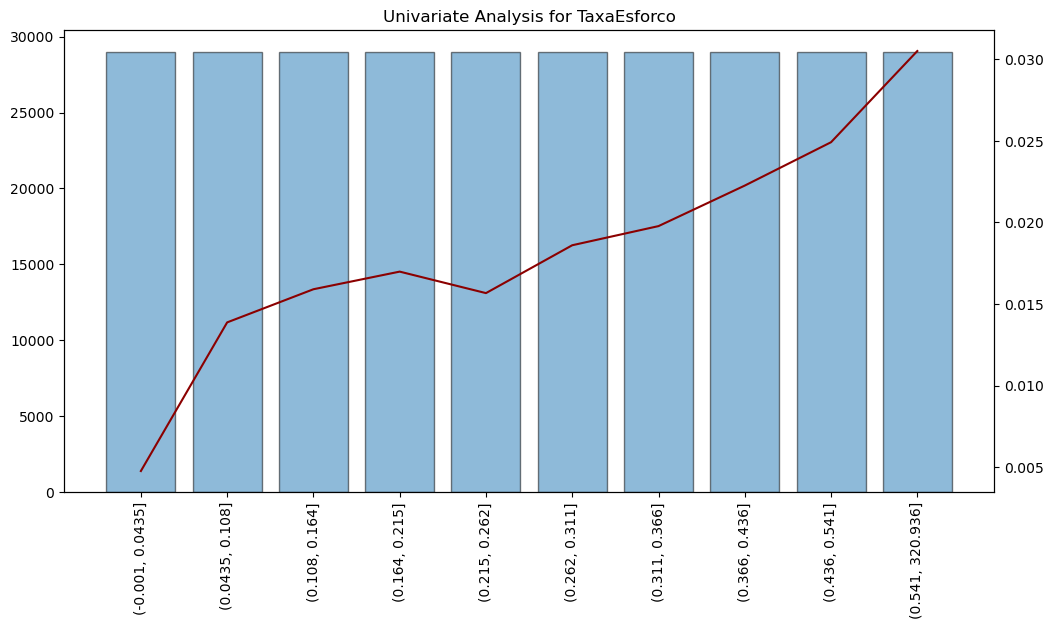

                  count      mean
TaxaEsforco                      
(-0.001, 0.0435]  28980  0.004762
(0.0435, 0.108]   28979  0.013872
(0.108, 0.164]    28987  0.015904
(0.164, 0.215]    28968  0.016984
(0.215, 0.262]    28978  0.015667
(0.262, 0.311]    28978  0.018600
(0.311, 0.366]    28978  0.019774
(0.366, 0.436]    28978  0.022258
(0.436, 0.541]    28978  0.024915
(0.541, 320.936]  28979  0.030505


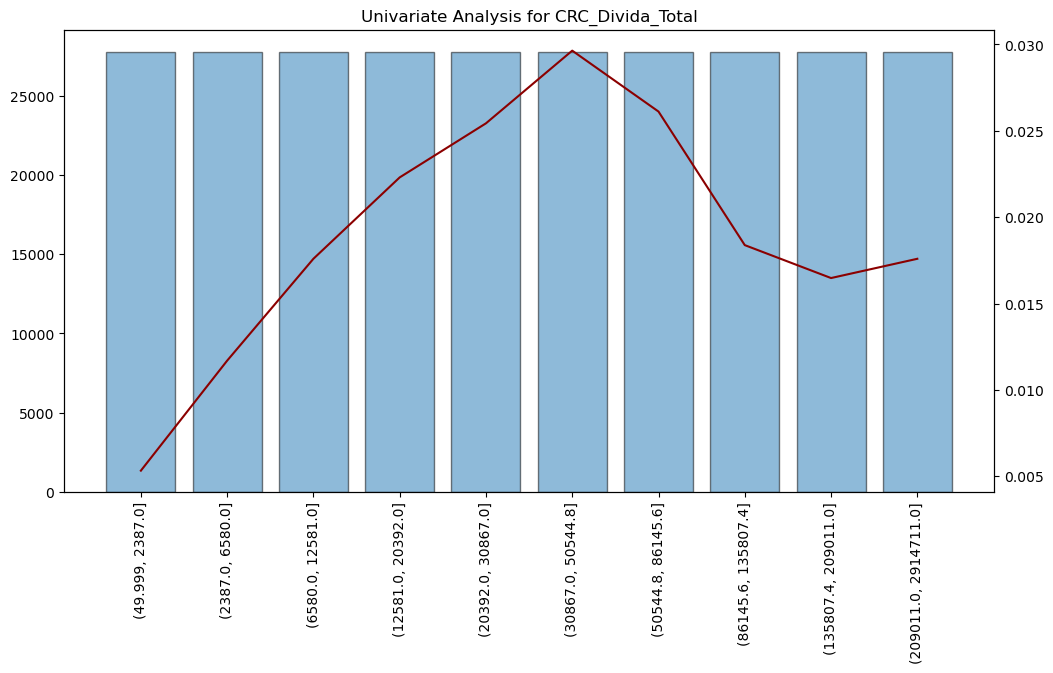

                       count      mean
CRC_Divida_Total                      
(49.999, 2387.0]       27807  0.005322
(2387.0, 6580.0]       27797  0.011692
(6580.0, 12581.0]      27798  0.017591
(12581.0, 20392.0]     27800  0.022302
(20392.0, 30867.0]     27798  0.025433
(30867.0, 50544.8]     27799  0.029641
(50544.8, 86145.6]     27800  0.026115
(86145.6, 135807.4]    27800  0.018381
(135807.4, 209011.0]   27800  0.016475
(209011.0, 2914711.0]  27800  0.017590


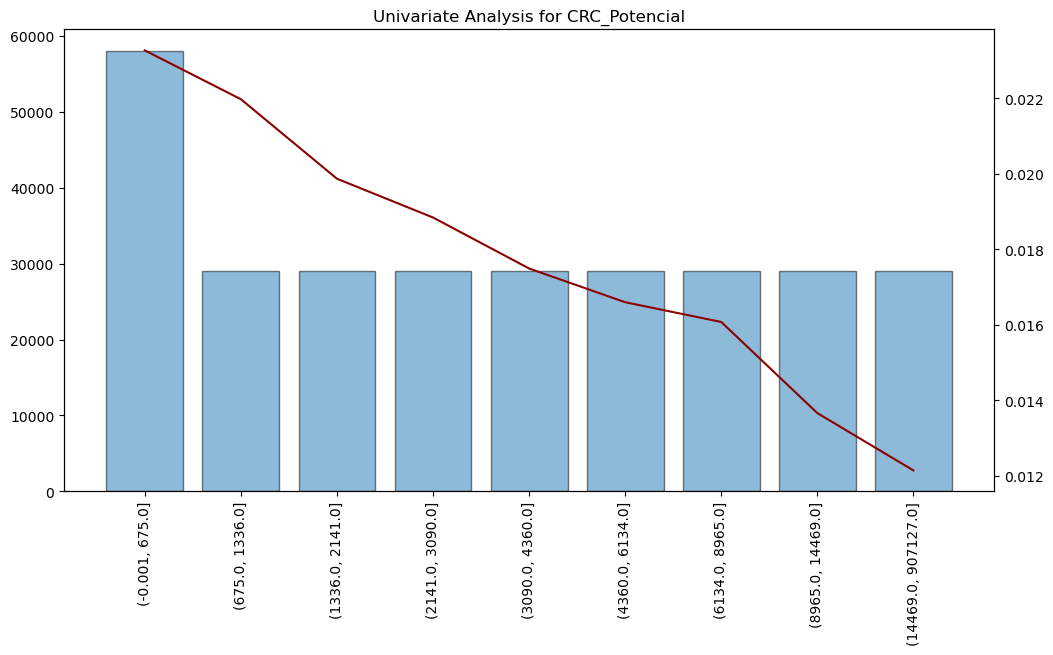

                     count      mean
CRC_Potencial                       
(-0.001, 675.0]      57966  0.023272
(675.0, 1336.0]      28982  0.021979
(1336.0, 2141.0]     28983  0.019874
(2141.0, 3090.0]     28971  0.018846
(3090.0, 4360.0]     28978  0.017496
(4360.0, 6134.0]     28971  0.016603
(6134.0, 8965.0]     28981  0.016080
(8965.0, 14469.0]    28976  0.013666
(14469.0, 907127.0]  28975  0.012148


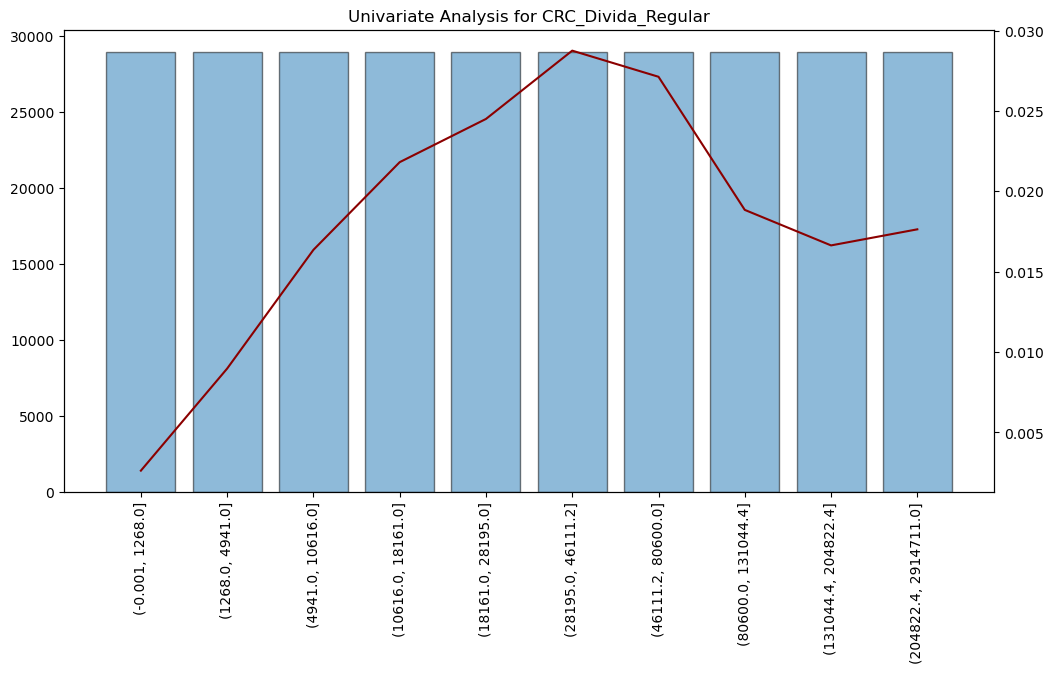

                       count      mean
CRC_Divida_Regular                    
(-0.001, 1268.0]       28984  0.002622
(1268.0, 4941.0]       28977  0.008973
(4941.0, 10616.0]      28978  0.016357
(10616.0, 18161.0]     28975  0.021812
(18161.0, 28195.0]     28980  0.024500
(28195.0, 46111.2]     28976  0.028748
(46111.2, 80600.0]     28979  0.027123
(80600.0, 131044.4]    28977  0.018843
(131044.4, 204822.4]   28978  0.016633
(204822.4, 2914711.0]  28979  0.017633


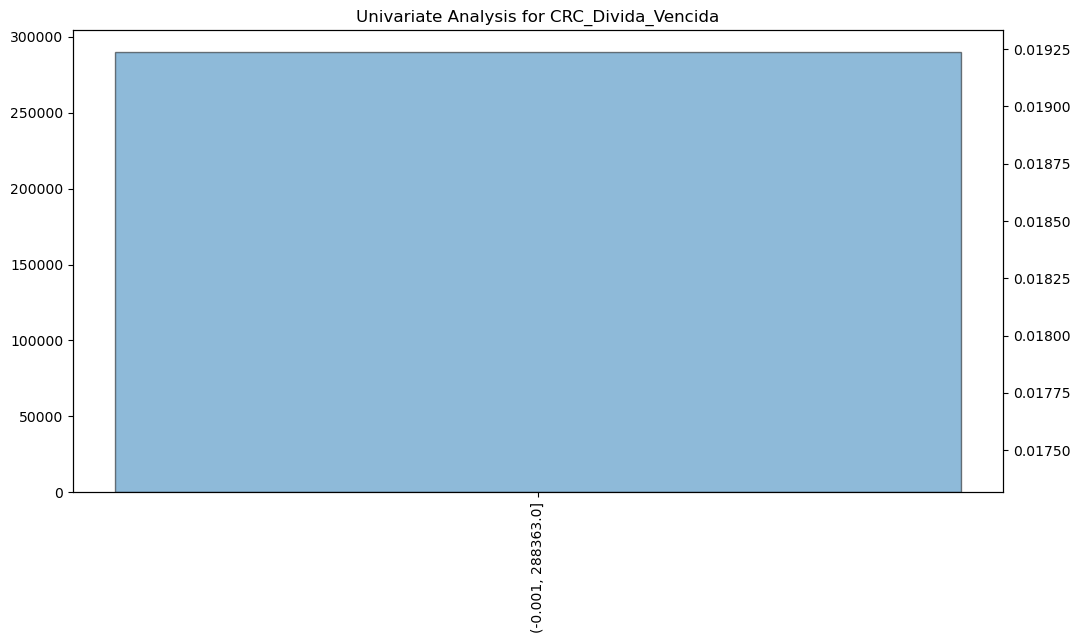

                     count      mean
CRC_Divida_Vencida                  
(-0.001, 288363.0]  289783  0.018324


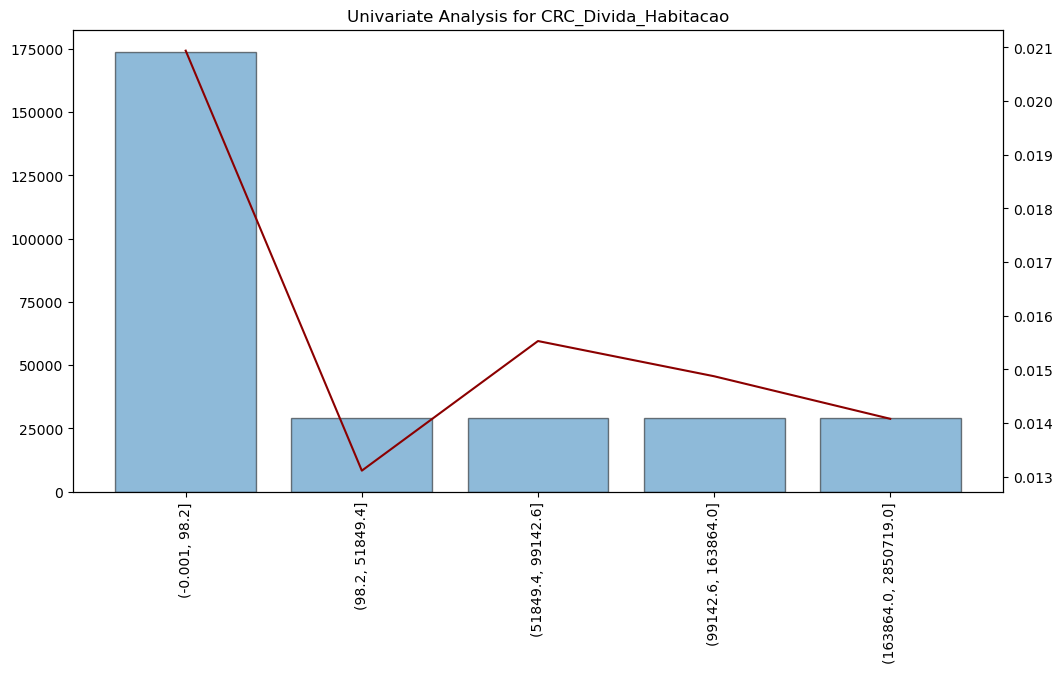

                        count      mean
CRC_Divida_Habitacao                   
(-0.001, 98.2]         173870  0.020941
(98.2, 51849.4]         28978  0.013113
(51849.4, 99142.6]      28978  0.015529
(99142.6, 163864.0]     28979  0.014873
(163864.0, 2850719.0]   28978  0.014080


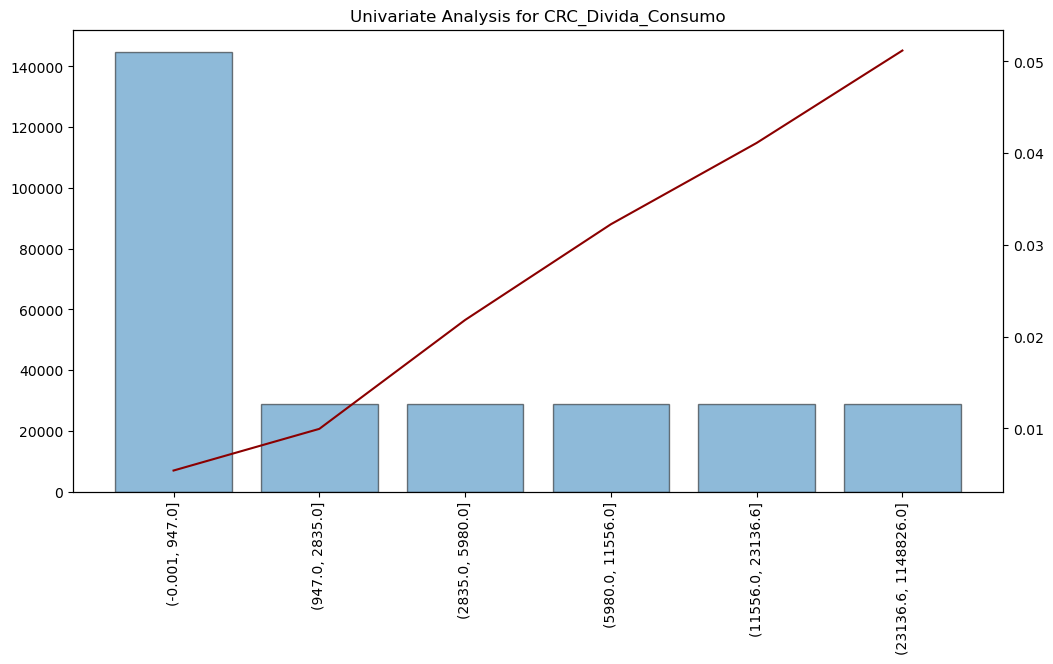

                       count      mean
CRC_Divida_Consumo                    
(-0.001, 947.0]       144892  0.005397
(947.0, 2835.0]        28979  0.009938
(2835.0, 5980.0]       28984  0.021805
(5980.0, 11556.0]      28972  0.032238
(11556.0, 23136.6]     28977  0.041102
(23136.6, 1148826.0]   28979  0.051175


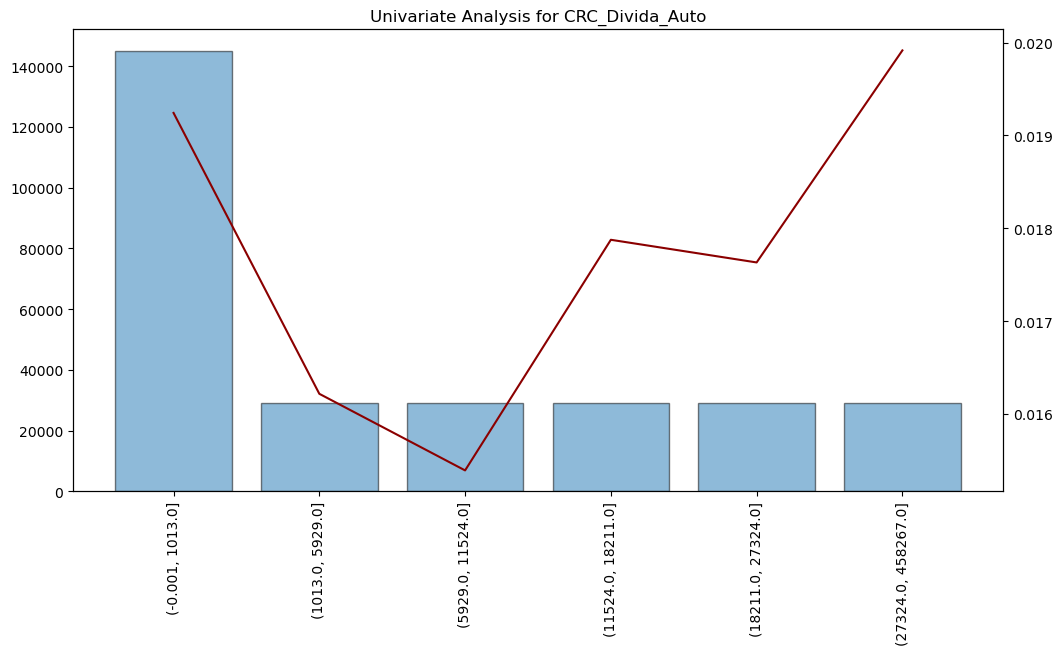

                      count      mean
CRC_Divida_Auto                      
(-0.001, 1013.0]     144892  0.019242
(1013.0, 5929.0]      28982  0.016217
(5929.0, 11524.0]     28976  0.015392
(11524.0, 18211.0]    28978  0.017876
(18211.0, 27324.0]    28982  0.017632
(27324.0, 458267.0]   28973  0.019915


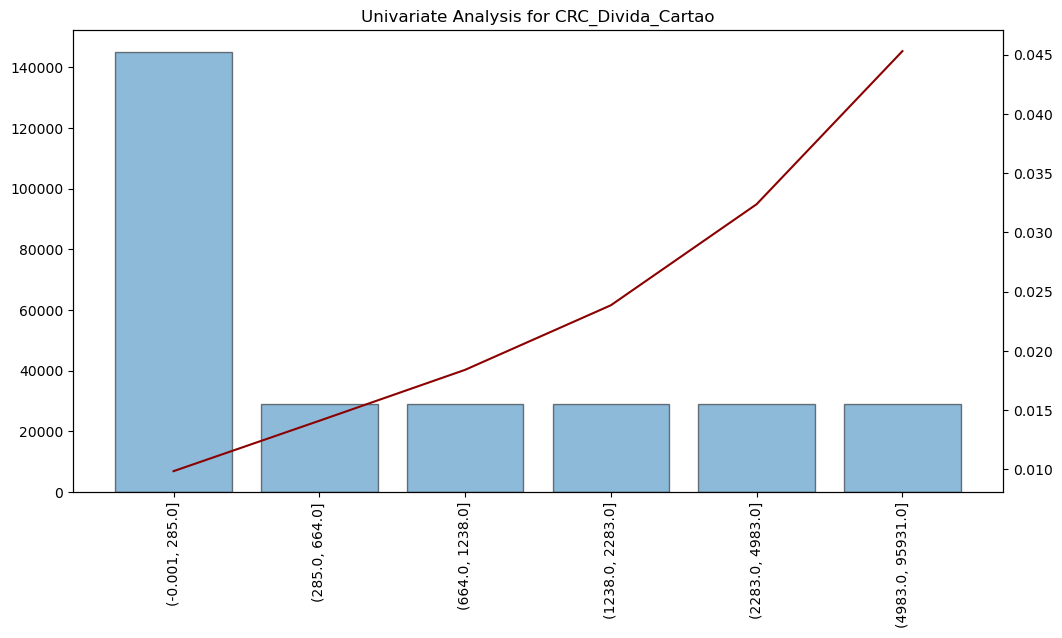

                    count      mean
CRC_Divida_Cartao                  
(-0.001, 285.0]    144967  0.009851
(285.0, 664.0]      28933  0.014102
(664.0, 1238.0]     28968  0.018400
(1238.0, 2283.0]    28975  0.023848
(2283.0, 4983.0]    28972  0.032376
(4983.0, 95931.0]   28968  0.045291


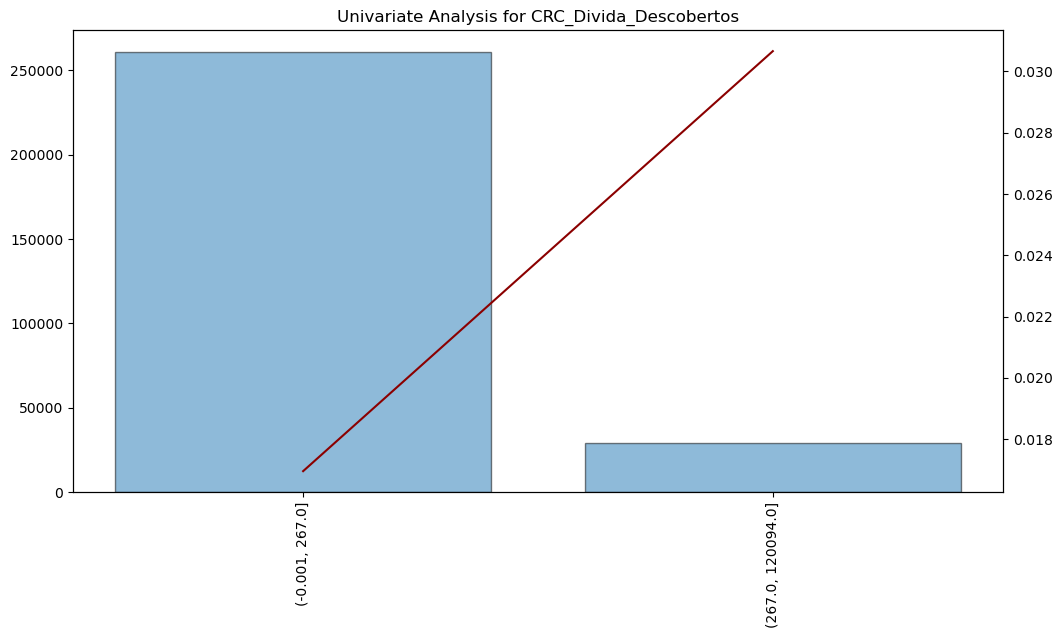

                         count      mean
CRC_Divida_Descobertos                  
(-0.001, 267.0]         260820  0.016954
(267.0, 120094.0]        28963  0.030660


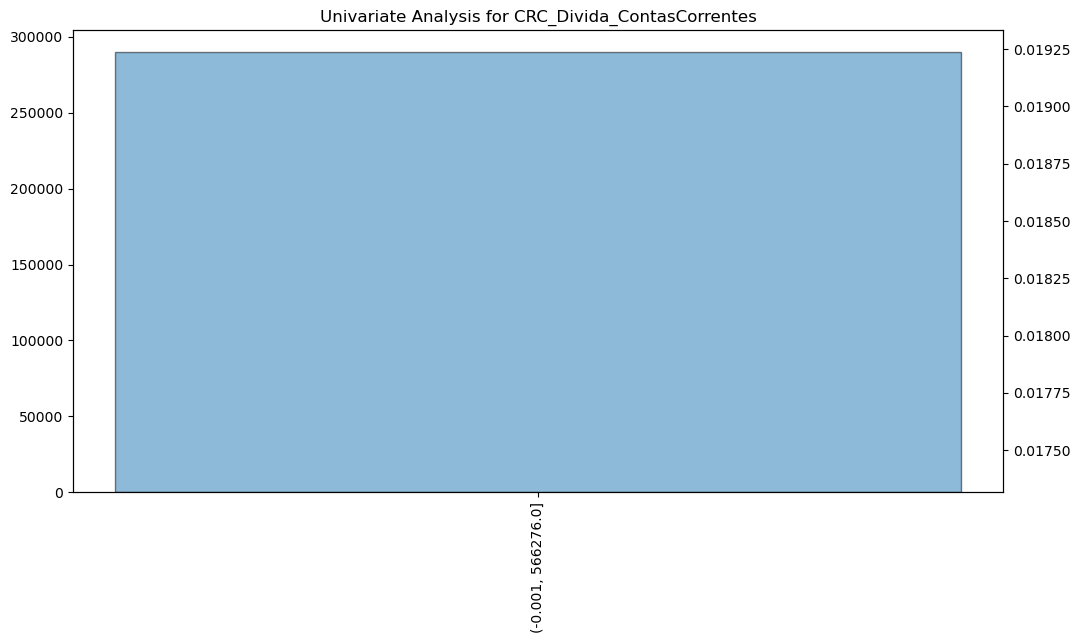

                             count      mean
CRC_Divida_ContasCorrentes                  
(-0.001, 566276.0]          289783  0.018324


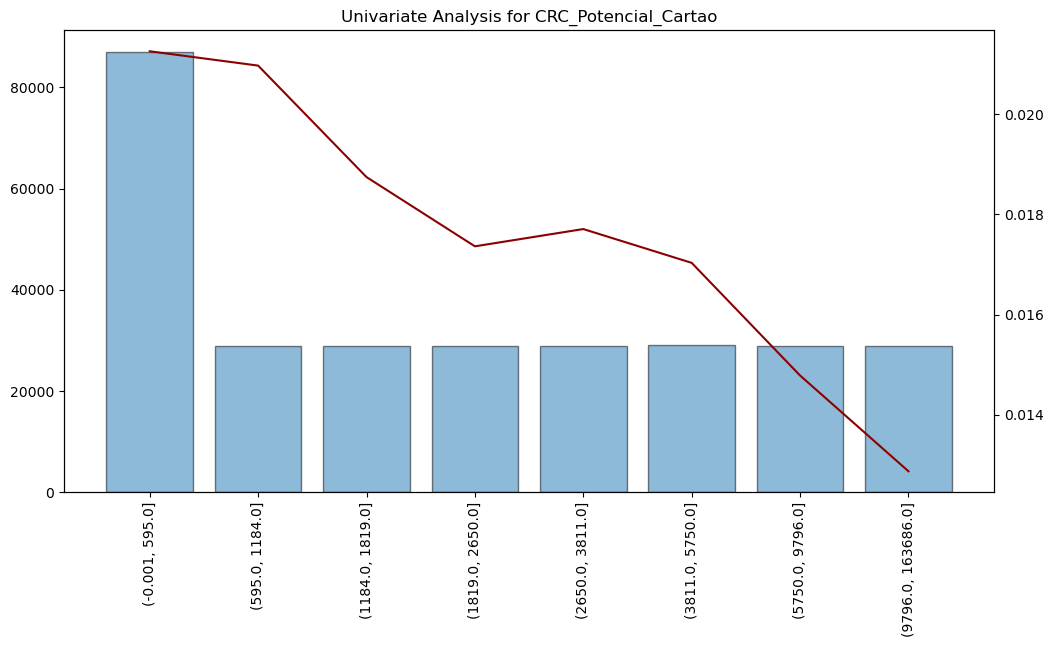

                      count      mean
CRC_Potencial_Cartao                 
(-0.001, 595.0]       86944  0.021255
(595.0, 1184.0]       28995  0.020969
(1184.0, 1819.0]      28969  0.018744
(1819.0, 2650.0]      28971  0.017362
(2650.0, 3811.0]      28972  0.017707
(3811.0, 5750.0]      29004  0.017032
(5750.0, 9796.0]      28951  0.014784
(9796.0, 163686.0]    28977  0.012872


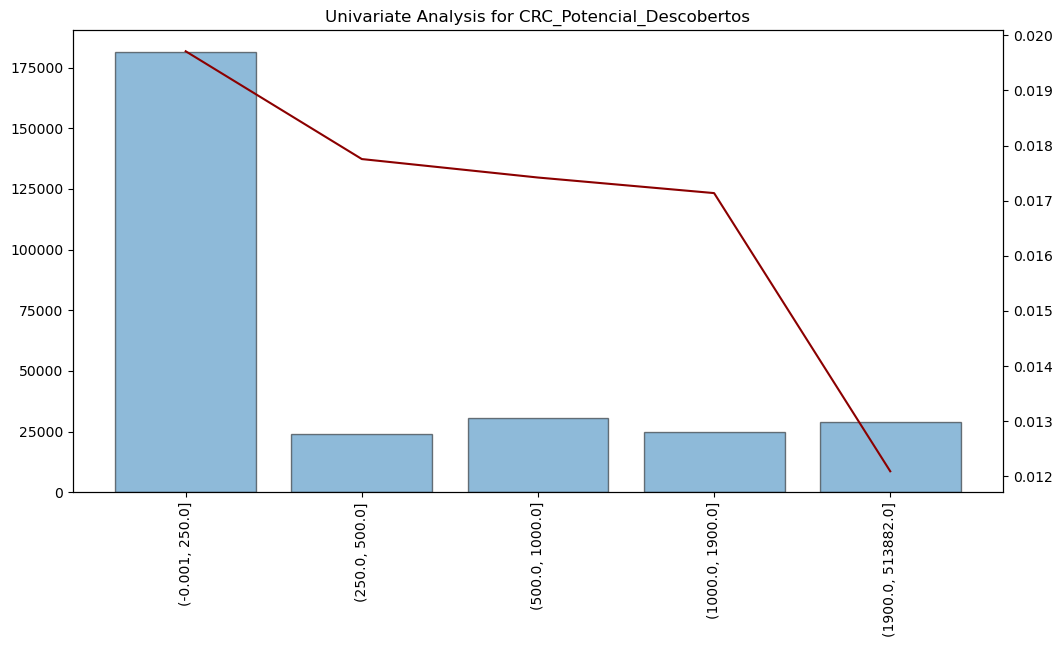

                            count      mean
CRC_Potencial_Descobertos                  
(-0.001, 250.0]            181278  0.019710
(250.0, 500.0]              24106  0.017755
(500.0, 1000.0]             30712  0.017420
(1000.0, 1900.0]            24741  0.017138
(1900.0, 513882.0]          28946  0.012091


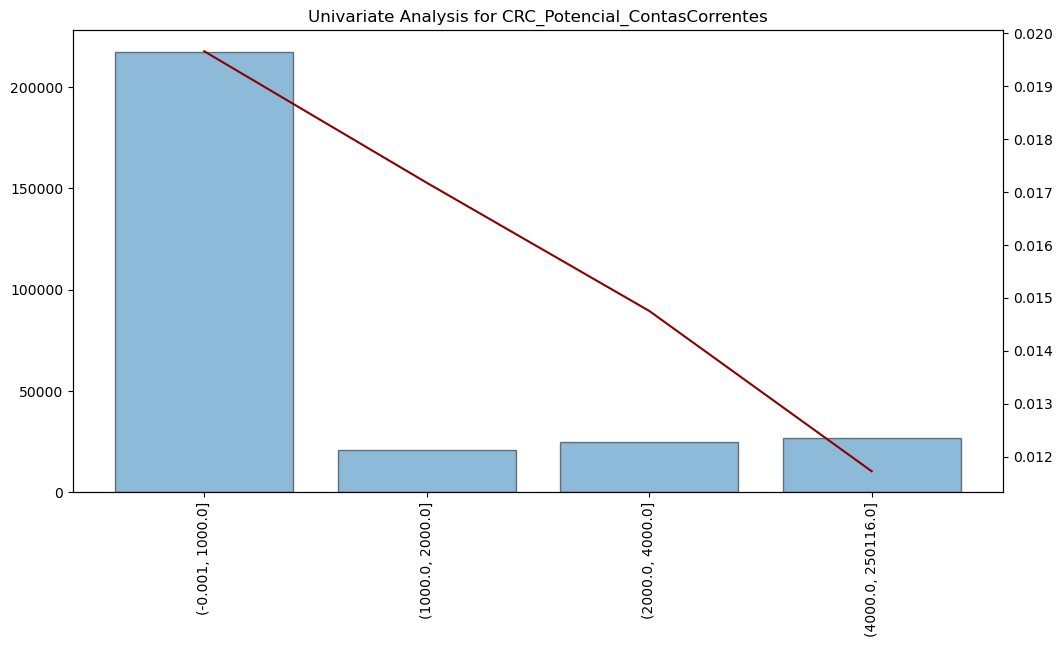

                                count      mean
CRC_Potencial_ContasCorrentes                  
(-0.001, 1000.0]               217159  0.019658
(1000.0, 2000.0]                21019  0.017175
(2000.0, 4000.0]                24739  0.014754
(4000.0, 250116.0]              26866  0.011725


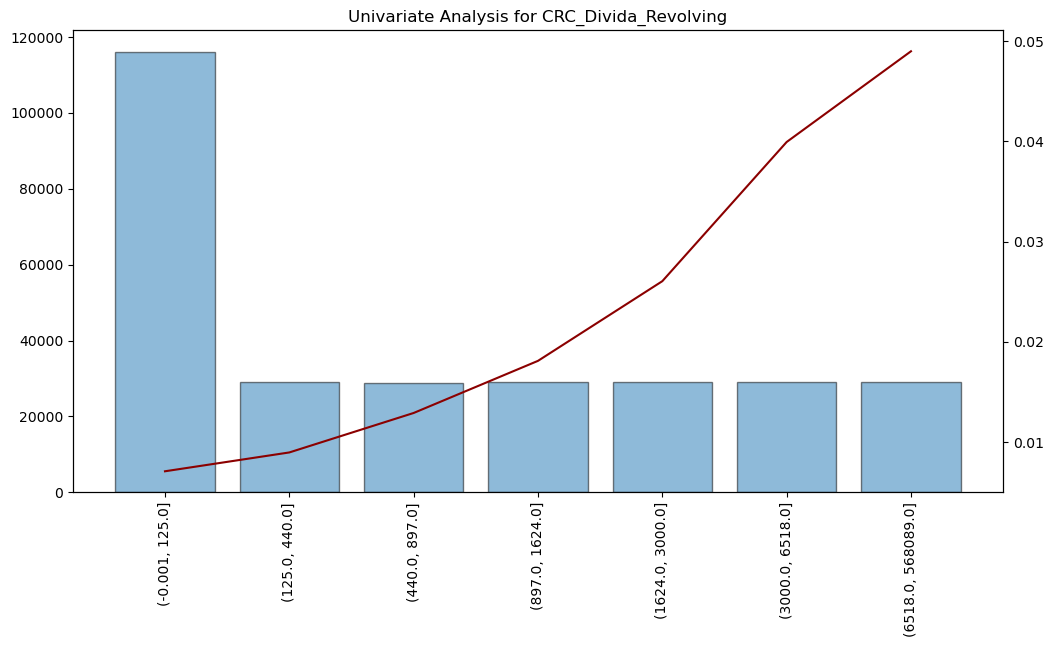

                       count      mean
CRC_Divida_Revolving                  
(-0.001, 125.0]       115976  0.007088
(125.0, 440.0]         28999  0.008966
(440.0, 897.0]         28910  0.012902
(897.0, 1624.0]        29004  0.018101
(1624.0, 3000.0]       28947  0.026048
(3000.0, 6518.0]       28976  0.039930
(6518.0, 568089.0]     28971  0.048980


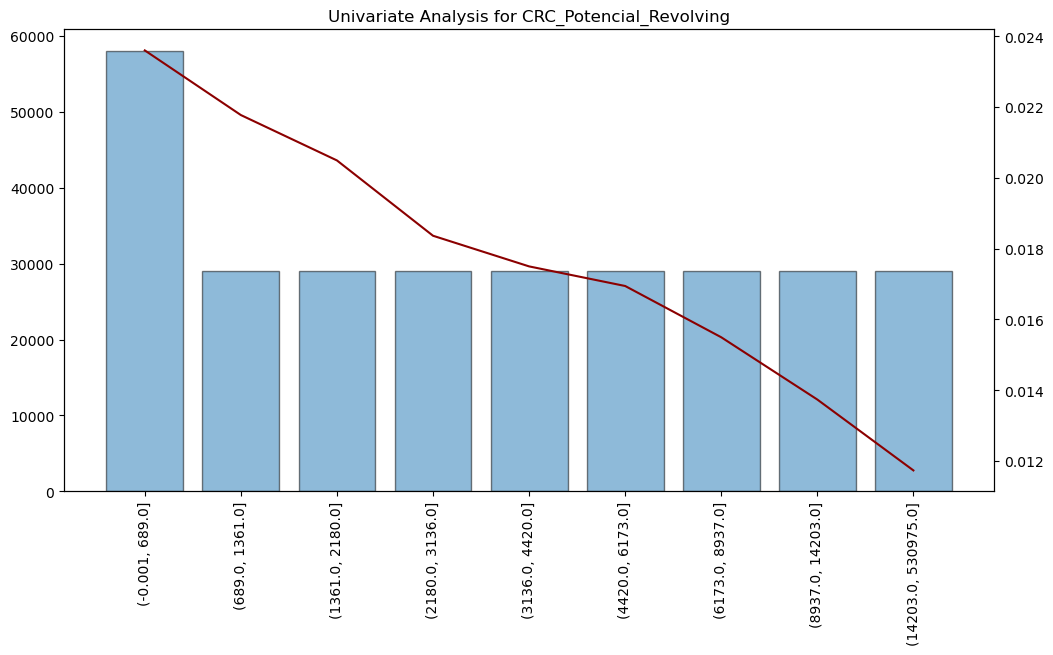

                         count      mean
CRC_Potencial_Revolving                 
(-0.001, 689.0]          57963  0.023601
(689.0, 1361.0]          28979  0.021774
(1361.0, 2180.0]         28987  0.020492
(2180.0, 3136.0]         28970  0.018364
(3136.0, 4420.0]         28975  0.017498
(4420.0, 6173.0]         28978  0.016944
(6173.0, 8937.0]         28977  0.015495
(8937.0, 14203.0]        28976  0.013736
(14203.0, 530975.0]      28978  0.011733


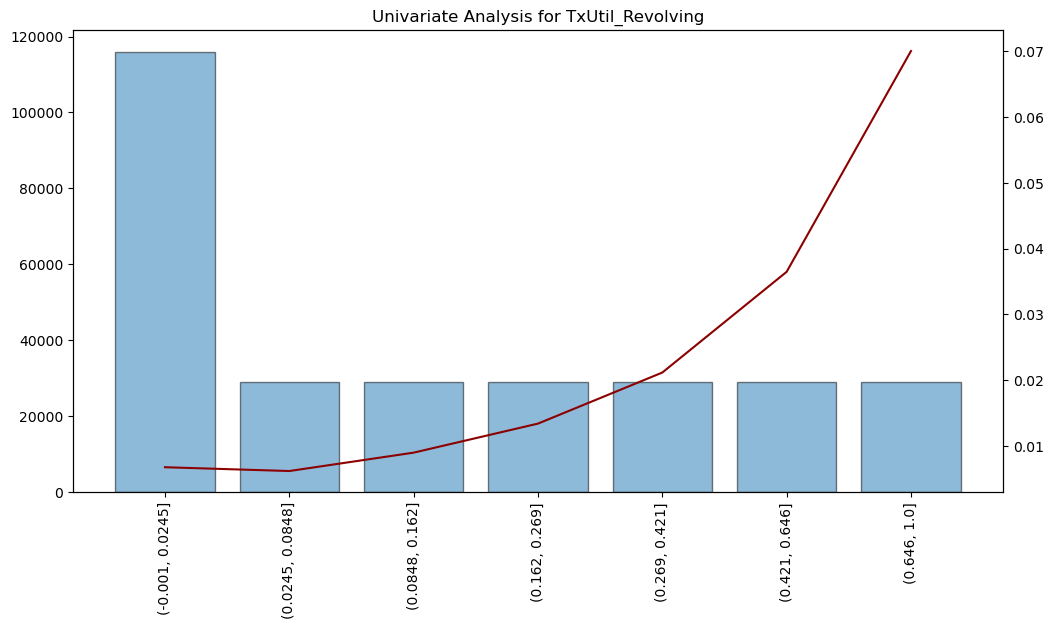

                   count      mean
TxUtil_Revolving                  
(-0.001, 0.0245]  115913  0.006755
(0.0245, 0.0848]   28979  0.006177
(0.0848, 0.162]    28978  0.008972
(0.162, 0.269]     28978  0.013389
(0.269, 0.421]     28978  0.021154
(0.421, 0.646]     28980  0.036473
(0.646, 1.0]       28977  0.070056


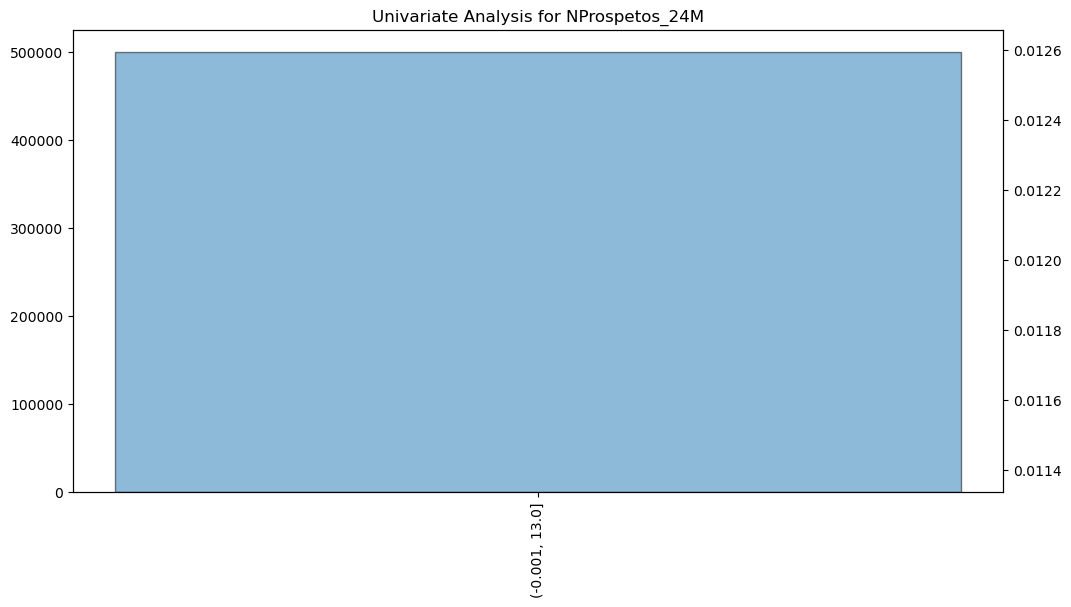

                 count      mean
NProspetos_24M                  
(-0.001, 13.0]  500000  0.011998


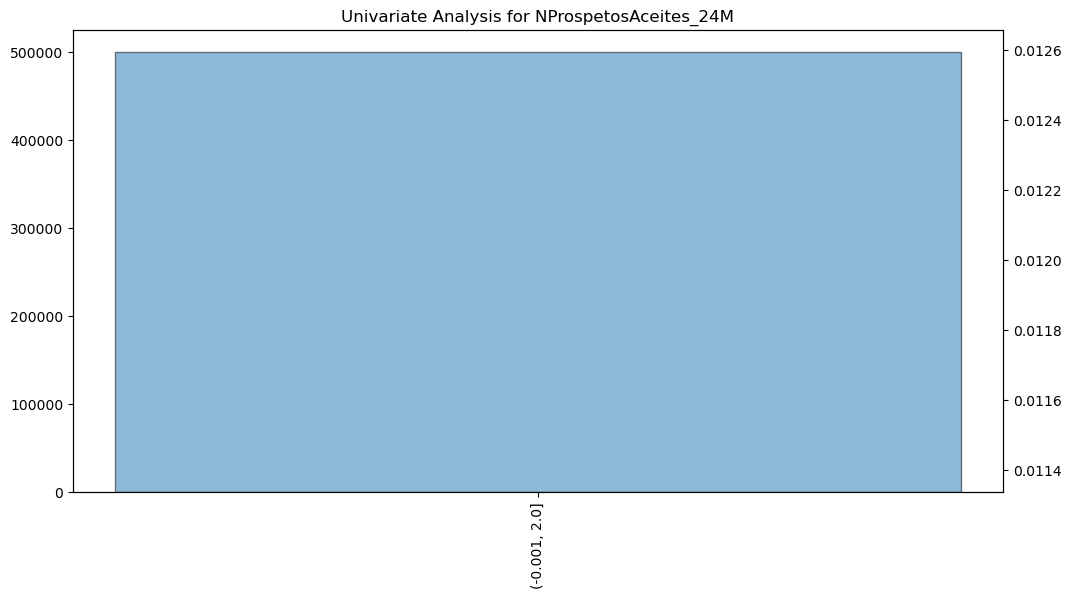

                        count      mean
NProspetosAceites_24M                  
(-0.001, 2.0]          500000  0.011998


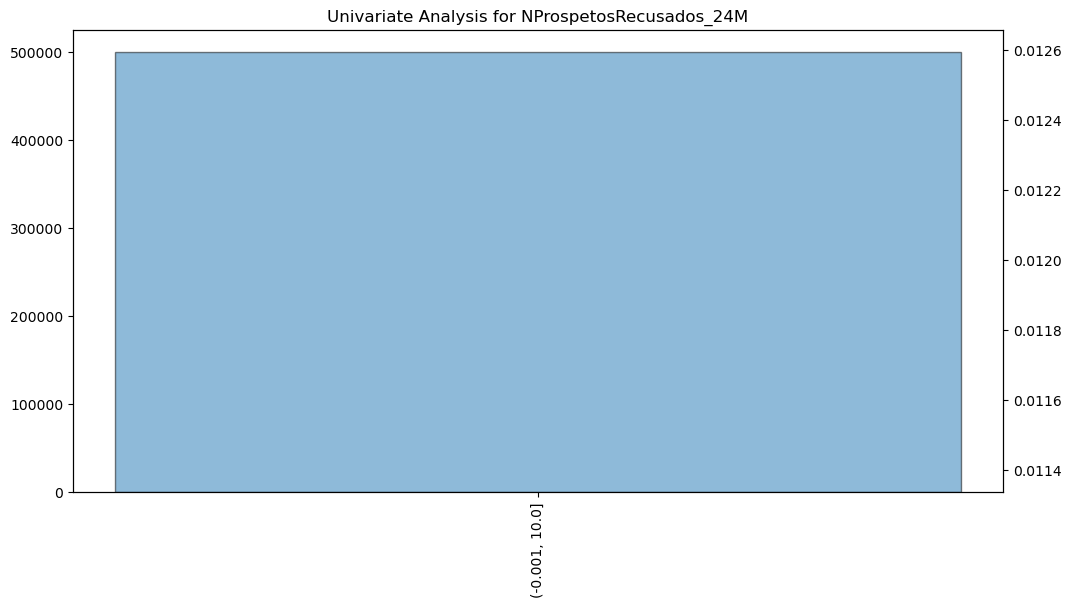

                          count      mean
NProspetosRecusados_24M                  
(-0.001, 10.0]           500000  0.011998


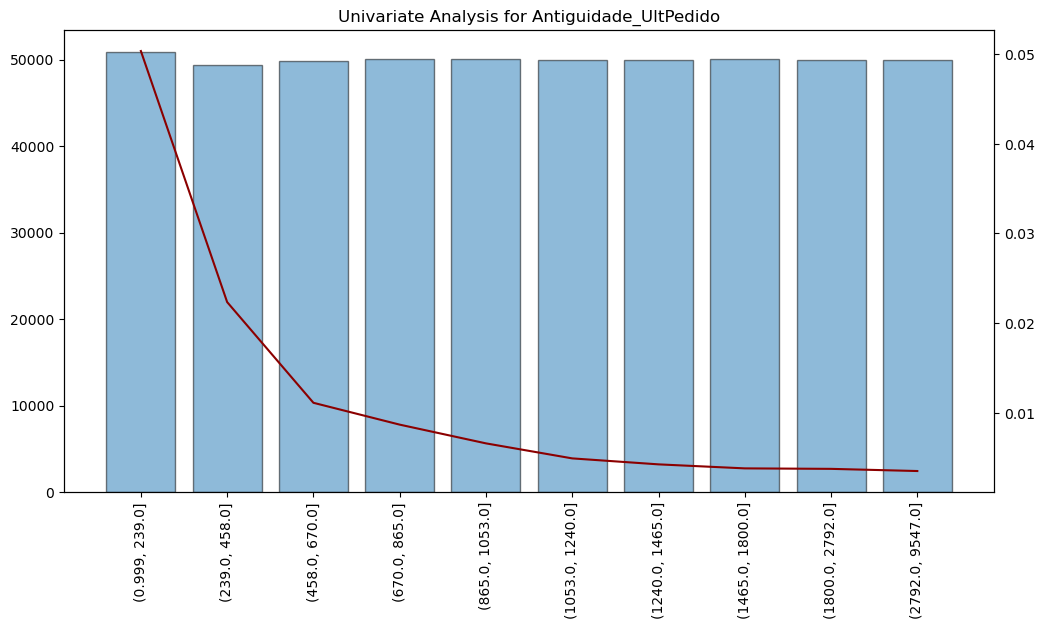

                       count      mean
Antiguidade_UltPedido                 
(0.999, 239.0]         50873  0.050341
(239.0, 458.0]         49344  0.022353
(458.0, 670.0]         49785  0.011128
(670.0, 865.0]         50041  0.008693
(865.0, 1053.0]        50118  0.006604
(1053.0, 1240.0]       49899  0.004930
(1240.0, 1465.0]       49951  0.004264
(1465.0, 1800.0]       50043  0.003817
(1800.0, 2792.0]       49959  0.003763
(2792.0, 9547.0]       49984  0.003521


In [11]:
kbins_univariate(df, continuas)

> Variáveis Categóricas
> Olhando para os resultados da distribuição das variaveis categorical e pensando nas questões abaixo conclusões podemos tirar:

 * Há evidências de capacidade discriminativa das variáveis?

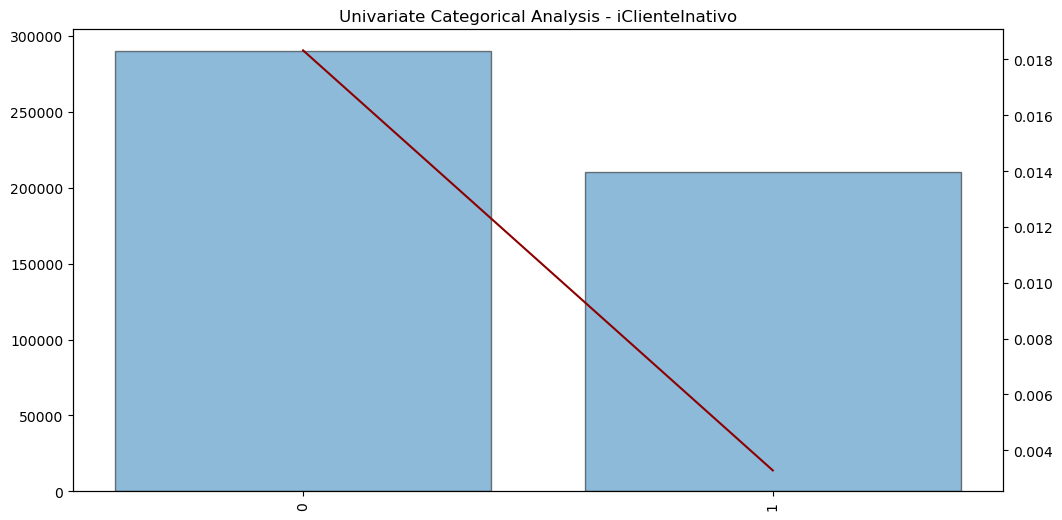

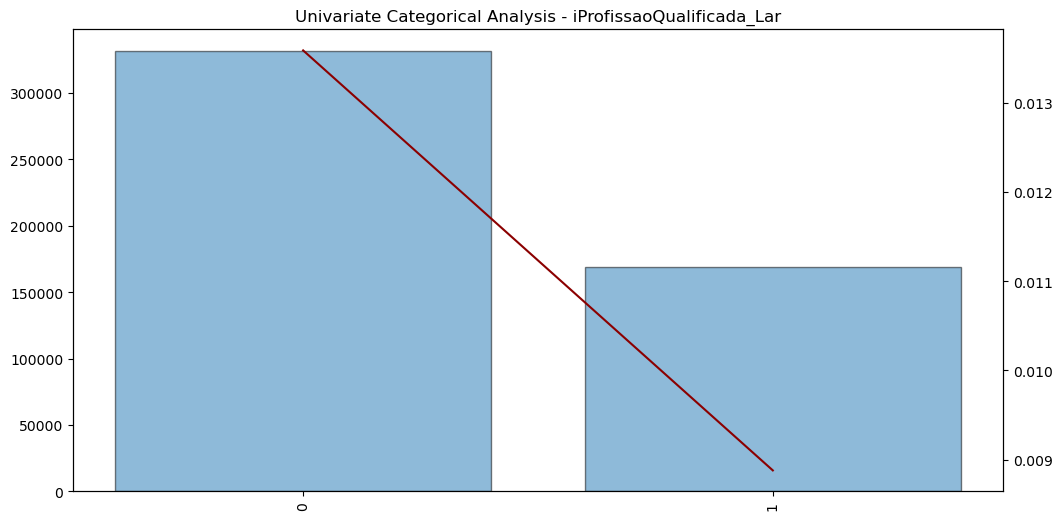

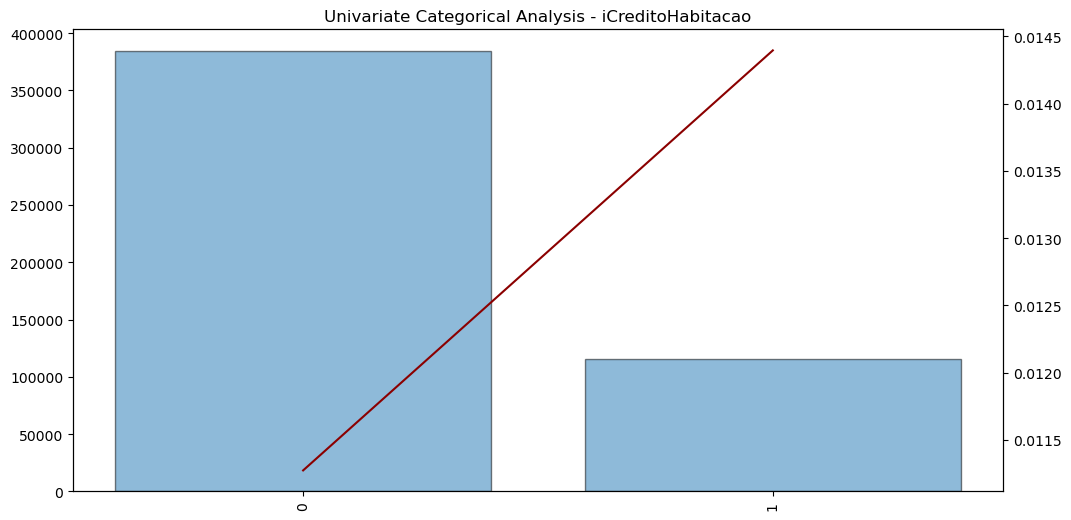

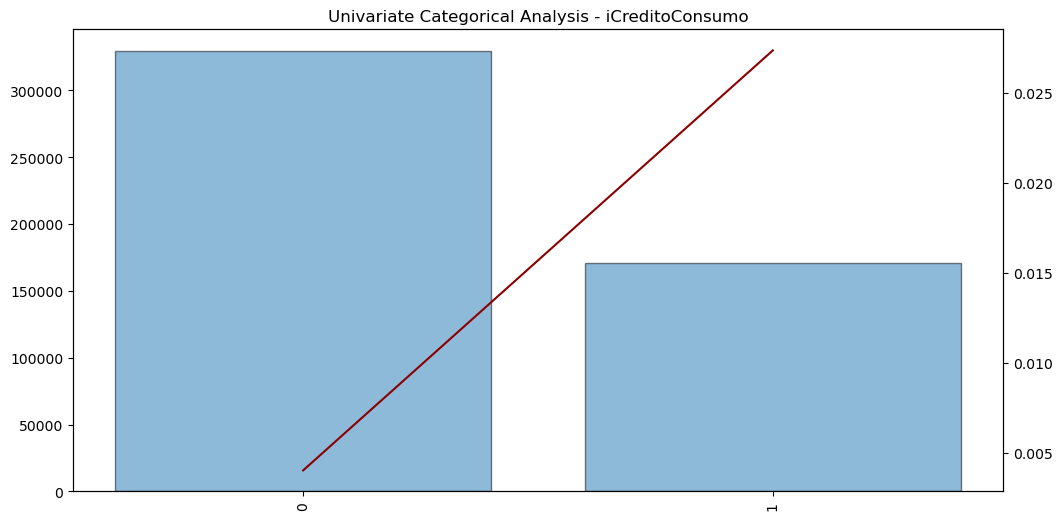

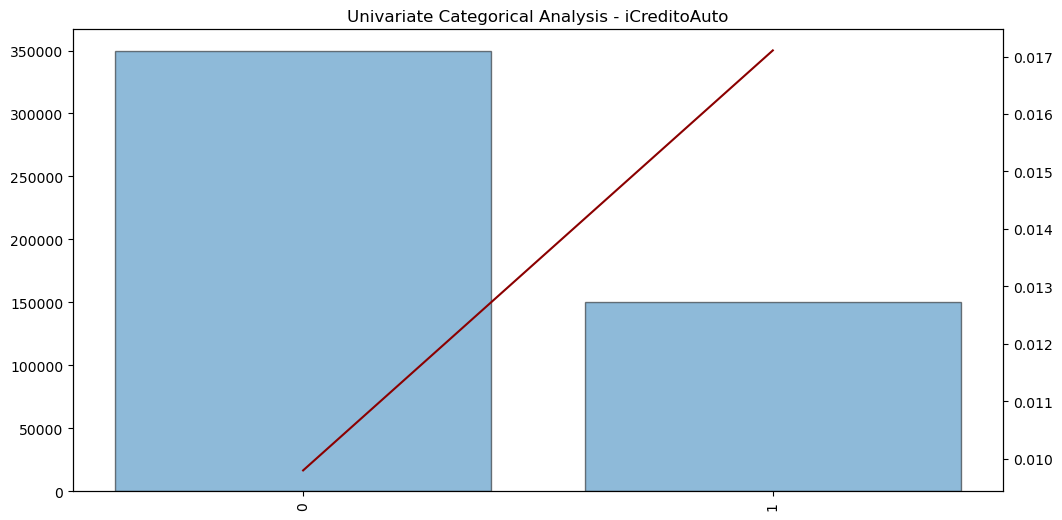

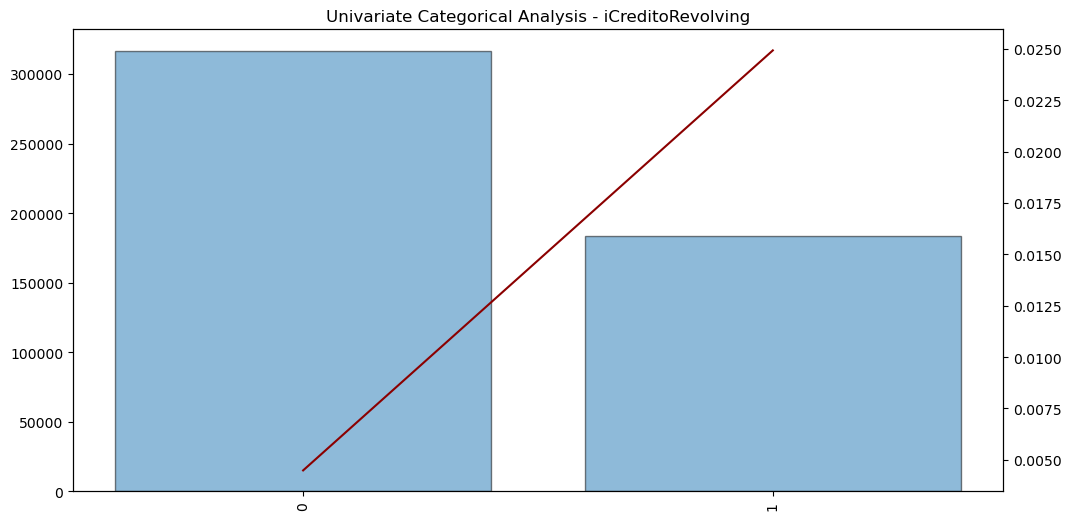

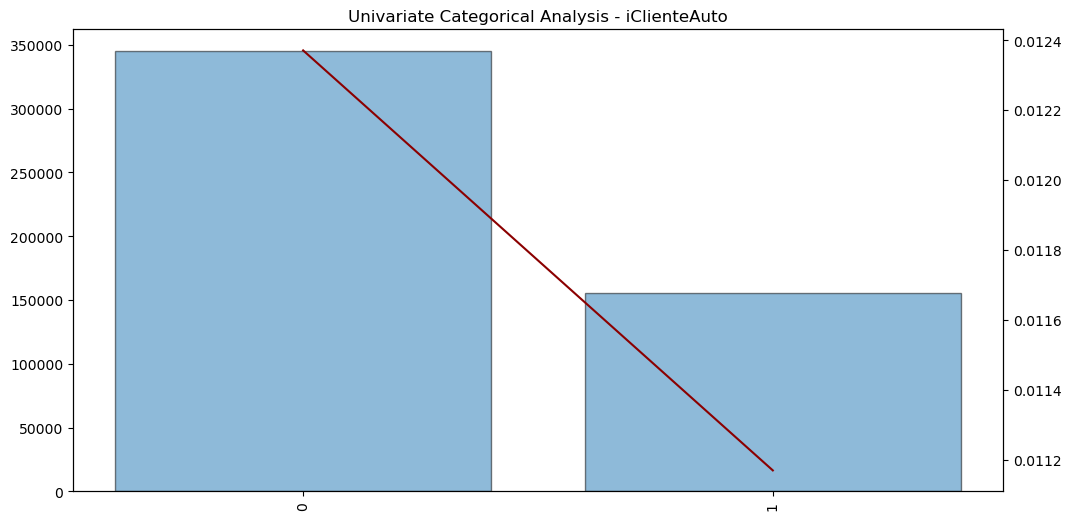

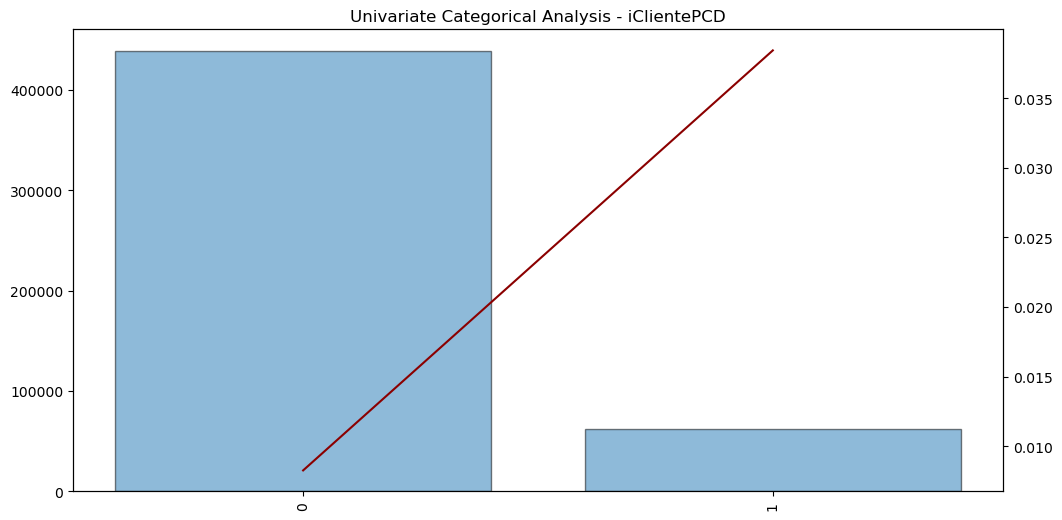

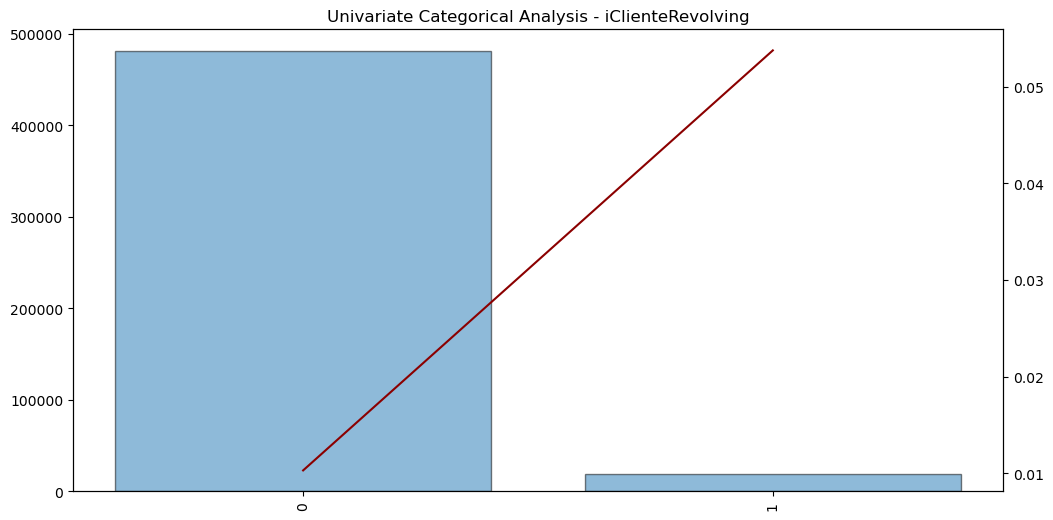

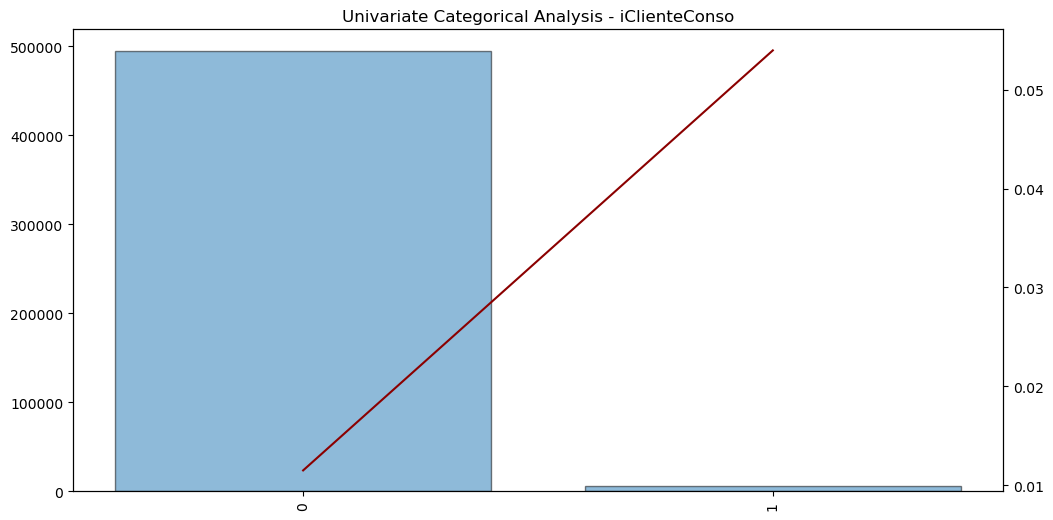

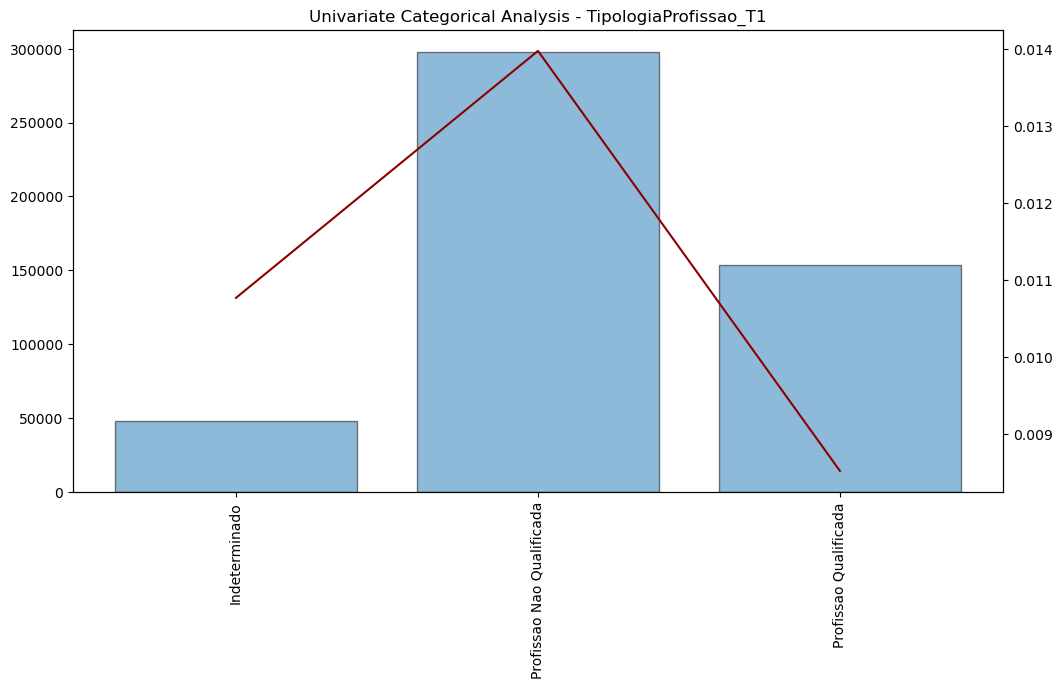

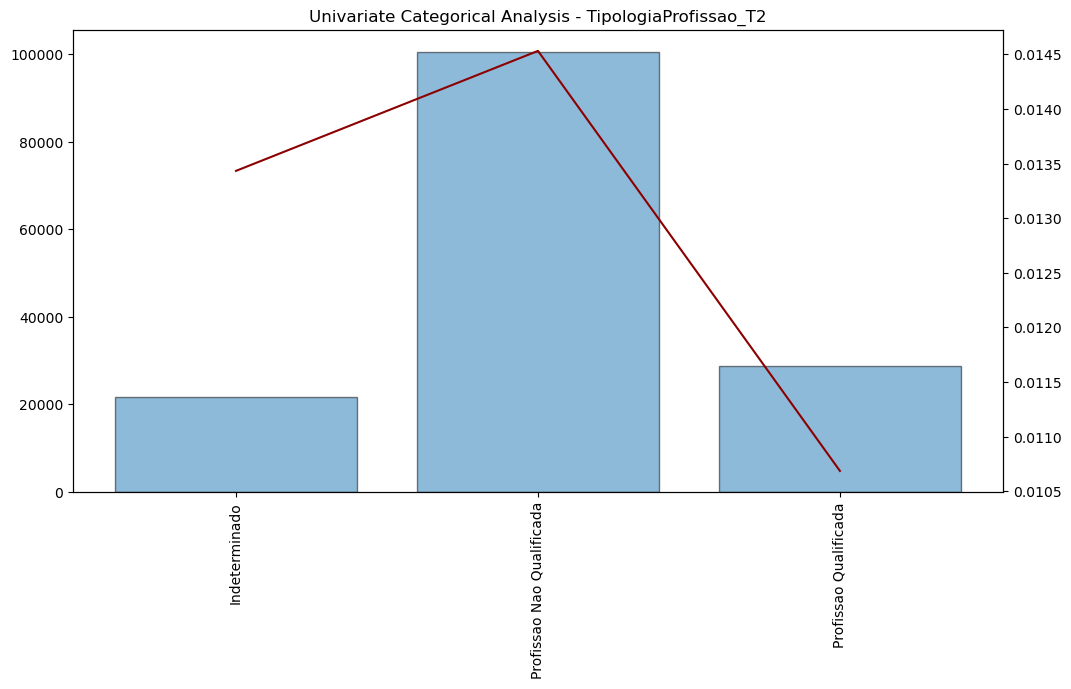

In [12]:
categorical_univariate(df,cat)

> Transformações <br>
> O processo de tratamento de dados + tranformações não é unidireccional, em vários momentos teremos de recuar do momento de modelação para o momento de trasformação de dados de acordo com os resultados que vamos obtendo.<br>
> Iniciamos com a criação de novas variáveis usado as variáveis numéricas disponiveis.<br>

In [13]:
# Criar novas variáveis e ajustar outras de acordo com o que observamos nas análises univáriaveis 

df['Peso_DividaNaoHabitacao'] = (df['CRC_Divida_Total'] - df['CRC_Divida_Habitacao'])/df['CRC_Divida_Total']

df['iSemDividaHabitacao'] = np.where(df['CRC_Divida_Habitacao'] == 0, 1, 0)
df['DividaHabitacao'] = np.where(df['CRC_Divida_Habitacao'].isnull(), 0, df['CRC_Divida_Habitacao'])

df['iSemDividaConsumo'] = np.where(df['CRC_Divida_Consumo'] == 0, 1, 0)
df['DividaConsumo'] = np.where(df['CRC_Divida_Consumo'].isnull(), 0, df['CRC_Divida_Consumo'])

df['iSemDividaRevolving'] = np.where(df['CRC_Divida_Revolving'] == 0, 1, 0)
df['DividaRevolving'] = np.where(df['CRC_Divida_Revolving'].isnull(), 0, df['CRC_Divida_Revolving'])

df['iSemDividaPotencial'] = np.where(df['CRC_Potencial'] == 0, 1, 0)
df['DividaPotencial'] = np.where(df['CRC_Potencial'].isnull(), 0, df['CRC_Potencial'])

df['TxEsforco'] = np.where(df['TaxaEsforco'].isnull(), 0, df['TaxaEsforco'])

df['Max_NumDependentes'] = np.where(df['Max_NumDependentes'].isnull(), 0, df['Max_NumDependentes'])

> Winsorizing or winsorization é um processo de transformação de dados que aplica limites **TreashHolds** para remover outliers. <br> 
> Recordem-se valores extremos impactam o comportamento da lógistica por isso devemos acautelar essa situação com aplicação de métodos que removem outliers da nossa amostra de treino.

In [14]:
df = df[df['DividaHabitacao'] <= df['DividaHabitacao'].quantile(0.999)].copy()
df = df[df['DividaConsumo'] <= df['DividaConsumo'].quantile(0.999)].copy()
df = df[df['DividaRevolving'] <= df['DividaRevolving'].quantile(0.999)].copy()
df = df[df['DividaPotencial'] <= df['DividaPotencial'].quantile(0.999)].copy()

> Eliminar Registos que não tiveram imputação correta de dados

In [15]:
df = df[(df['Max_AntiguidadeProfissional'] > 0) & (~df['Max_AntiguidadeProfissional'].isnull())].copy()
df = df[~(df['Antiguidade_UltPedido'].isnull())].copy()

> Transformações Adicionais - Variaveis Categoricas

In [16]:
def modify_dataset(data):
    # Criação de classes para TipologiaProfissao_T1
    data['TipologiaProfissao_T1_Encoded'] = np.select(
        [
            data['TipologiaProfissao_T1'].isin(['Indeterminado']),
            data['TipologiaProfissao_T1'].isin(['Profissao Qualificada']),
            data['TipologiaProfissao_T1'].isin(['Profissao Nao Qualificada']),
        ],
        [
            1, 2, 3
        ],
        default=1
    )

    # Criação de classes para TipologiaProfissao_T2
    data['TipologiaProfissao_T2_Encoded'] = np.select(
        [
            data['TipologiaProfissao_T2'].isin(['Indeterminado']),
            data['TipologiaProfissao_T2'].isin(['Profissao Qualificada']),
            data['TipologiaProfissao_T2'].isin(['Profissao Nao Qualificada']),
        ],
        [
            1, 2, 3
        ],
        default=1
    )
       
    categoricas = ['TipologiaProfissao_T1_Encoded','TipologiaProfissao_T2_Encoded']
    # One-hot encoding para outras variáveis categóricas
    for col in categoricas:
        one_hot_encoded = pd.get_dummies(data[col], prefix=col, dtype=int)
        data = pd.concat([data, one_hot_encoded], axis=1)
        data.drop(col, axis=1, inplace=True)
         
    return data

In [17]:
# aplicar as transformações 
df = modify_dataset(df);
df.reset_index(drop = True, inplace = True);

In [18]:
# fazer cópia do dataframe
df_model = df.copy();
df_model.reset_index(drop = True, inplace = True);

___
## Selecção de Variáveis e Modelação <a class="anchor" id="chapter8"></a>

   * Seleção de Variáveis;
   * Modelação;
   * Avaliação de resultados;

> Existem algoritmos e técnicas que podemos usar na seleção de variáveis que nos permitem ultrapassar ou minimizar a escolha de variáveis correlacionadas, por isso é uma boa prática manter todas as variáveis até a fase de modelação ao invés de as excluir a priori.<br>

> Em todo há execpções como o ter em conta a **maldição da dimensionalidade**, ou usar **business oriented analysis** isto é o analista pode usar o seu conhecimento de negócio para excluir variáveis com base empírica.<br>

> O processo de seleção de variáveis pode ser realizado usando várias técnicas,**Análise Univariável**, **KBest**,**Regularização**, **CV+KF+ Algoritmo (ex: XGboost)** entre muitas outras.<br>

> Neste caso optamos por fazer através da seleção com base na análise univariável considerendo as análises já realizadas.<br>

> Por exemplo standardização não é necessário ao usar ***Tree Based Algoritms***, mas relevante quando usamos ***Regressões*** e variáveis com escalas diferentes, p.ex: Rendimentos que variam entre 0€ e 100000€ e idade que varia entre 18 e 100. <br>

> Conseguem olhando para estas variáveis entender a razão da sua escolha? <br>
> Que critérios é que podemos aplicar para fazer uma inspecção visual de uma variável? <br>

In [19]:
crc_debt_position = [
    'DividaHabitacao',
    'DividaConsumo',
    'DividaRevolving',
    'DividaPotencial'
]

financial_condition = [
    #'TxUtilRev',
    'TxEsforco'
]

socio_demographic = [
    'Max_Idade',
    #'Max_AntiguidadeProfissional',
    'iProfissaoQualificada_Lar',
    'Max_NumDependentes'
]

crc_products = [
    'iSemDividaHabitacao',
    'iSemDividaConsumo',
    'iSemDividaRevolving',
    'iSemDividaPotencial'
]

behavioral = [
    'iClienteInativo',
    'iClienteAuto',
    'iClientePCD',
    'iClienteRevolving',
    'iClienteConso',
    'NProspetos_24M',
    'Antiguidade_UltPedido'
]

target = 'Target'

model_variables = crc_debt_position + financial_condition + socio_demographic + crc_products + behavioral

In [20]:
df_model[model_variables].isnull().sum()

DividaHabitacao              0
DividaConsumo                0
DividaRevolving              0
DividaPotencial              0
TxEsforco                    0
Max_Idade                    0
iProfissaoQualificada_Lar    0
Max_NumDependentes           0
iSemDividaHabitacao          0
iSemDividaConsumo            0
iSemDividaRevolving          0
iSemDividaPotencial          0
iClienteInativo              0
iClienteAuto                 0
iClientePCD                  0
iClienteRevolving            0
iClienteConso                0
NProspetos_24M               0
Antiguidade_UltPedido        0
dtype: int64

> Divisão em Train e Test + Normalização

In [21]:
X, y = df_model[[x for x in model_variables]].copy(), df_model[target].copy()

In [22]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, crc_debt_position)
    ], remainder = 'passthrough'
)

Xt = pd.DataFrame(preprocessor.fit_transform(X),\
    columns = get_column_names(preprocessor, model_variables))

In [23]:
Xt.insert(0, 'Intercept', np.ones(len(Xt)))

In [24]:
Xt.head(5)

,Intercept,DividaHabitacao,DividaConsumo,DividaRevolving,DividaPotencial,TxEsforco,Max_Idade,iProfissaoQualificada_Lar,Max_NumDependentes,iSemDividaHabitacao,iSemDividaConsumo,iSemDividaRevolving,iSemDividaPotencial,iClienteInativo,iClienteAuto,iClientePCD,iClienteRevolving,iClienteConso,NProspetos_24M,Antiguidade_UltPedido
0,1.0,0.0,34.9,0.094,5.602,0.859739,36.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,147.0
1,1.0,0.0,0.0,0.000,0.000,0.000000,40.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,880.0
2,1.0,0.0,0.0,4.022,5.645,0.000000,43.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,504.0
3,1.0,0.0,0.0,0.393,7.327,0.328874,38.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,78.0
4,1.0,0.0,0.0,0.000,0.000,0.000000,45.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1785.0


In [25]:
Xt.describe().iloc[1,:]

Intercept                       1.000000
DividaHabitacao                28.990606
DividaConsumo                   4.603476
DividaRevolving                 1.426818
DividaPotencial                 3.450475
TxEsforco                       0.166365
Max_Idade                      46.599457
iProfissaoQualificada_Lar       0.385547
Max_NumDependentes              0.472661
iSemDividaHabitacao             0.330081
iSemDividaConsumo               0.211084
iSemDividaRevolving             0.197578
iSemDividaPotencial             0.059666
iClienteInativo                 0.432849
iClienteAuto                    0.196821
iClientePCD                     0.139095
iClienteRevolving               0.045734
iClienteConso                   0.013800
NProspetos_24M                  0.014278
Antiguidade_UltPedido        1424.007969
Name: mean, dtype: float64

In [26]:
train_index, validation_index = df_model[df_model['DtCampanha'] <= 20211031].index, df_model[df_model['DtCampanha'] > 20211031].index

In [27]:
X_train, y_train = Xt.iloc[train_index].copy(), y.iloc[train_index].copy()
X_valid, y_valid = Xt.iloc[validation_index].copy(), y.iloc[validation_index].copy()

> Correlação entre variaveis escolhidas

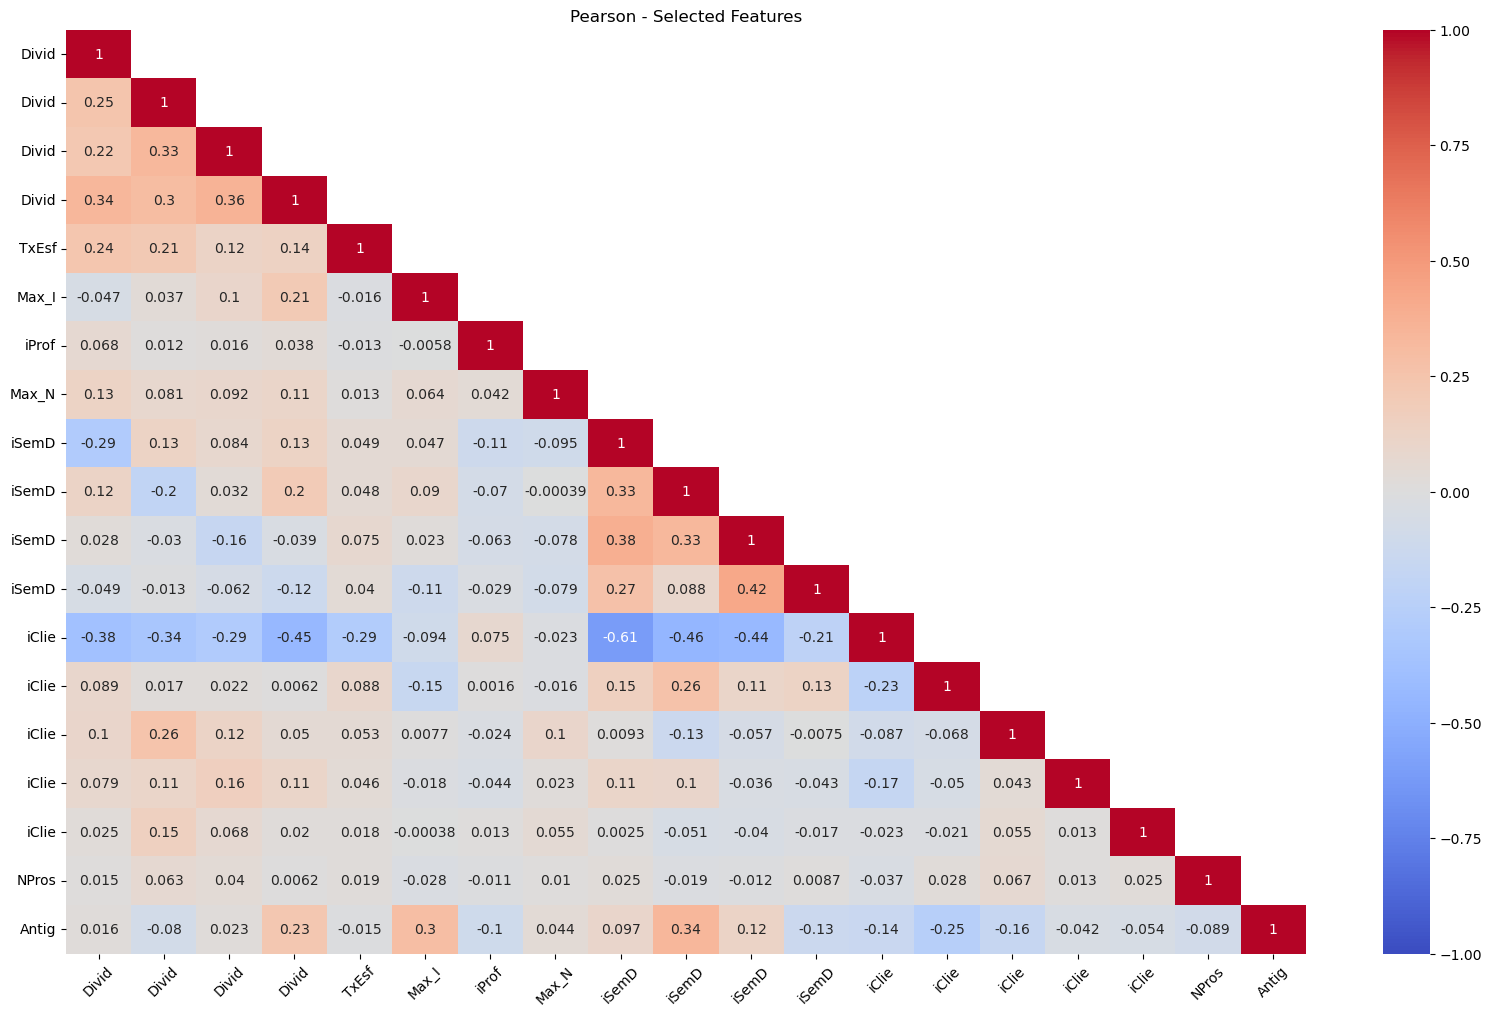

In [28]:
# Compute Pearson correlation matrix
corr_matrix = X_train[model_variables].corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Create a heatmap of the correlation matrix with the mask
plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)

# Formatting x and y tick labels to 6 characters
x_labels = [label[:5] for label in corr_matrix.columns]
y_labels = [label[:5] for label in corr_matrix.index]

# Set formatted labels
plt.xticks(ticks=np.arange(0.5, len(corr_matrix.columns), 1), labels=x_labels, rotation=45)
plt.yticks(ticks=np.arange(0.5, len(corr_matrix.index), 1), labels=y_labels, rotation=0)

plt.title('Pearson - Selected Features')
plt.show()

> OK, vamos lá treinar o nosso modelo !!!

> Modelação
> Usar kfold cross validation para analisar como se comporta o modelo em vaios subsets de dados ajuda-nos a ganhar confiança na capacidade do modelo continuamente mostrar bons resultados quando tenta prever para varios sub grupos diferentes. <br>

In [29]:
k = 10
kf = KFold(n_splits = k, shuffle = True, random_state = 1234)
kf_gini = []

i = 1
for train_index, test_index in kf.split(X_train):

    print("Evaluating on fold %d/%d"%(i, k))
    X_train_fold, y_train_fold = X_train.iloc[train_index].copy(), y_train.iloc[train_index].copy()
    X_test_fold, y_test_fold = X_train.iloc[test_index].copy(), y_train.iloc[test_index].copy()

    model = sm.Logit(y_train_fold, X_train_fold).fit(disp = False)

    gini_train = 2*roc_auc_score(y_train_fold, model.predict(X_train_fold)) - 1
    gini_test = 2*roc_auc_score(y_test_fold, model.predict(X_test_fold)) - 1

    kf_gini.append((gini_train, gini_test))
    
    i += 1

Evaluating on fold 1/10
Evaluating on fold 2/10
Evaluating on fold 3/10
Evaluating on fold 4/10
Evaluating on fold 5/10
Evaluating on fold 6/10
Evaluating on fold 7/10
Evaluating on fold 8/10
Evaluating on fold 9/10
Evaluating on fold 10/10


Text(0.5, 1.0, 'On test folds')

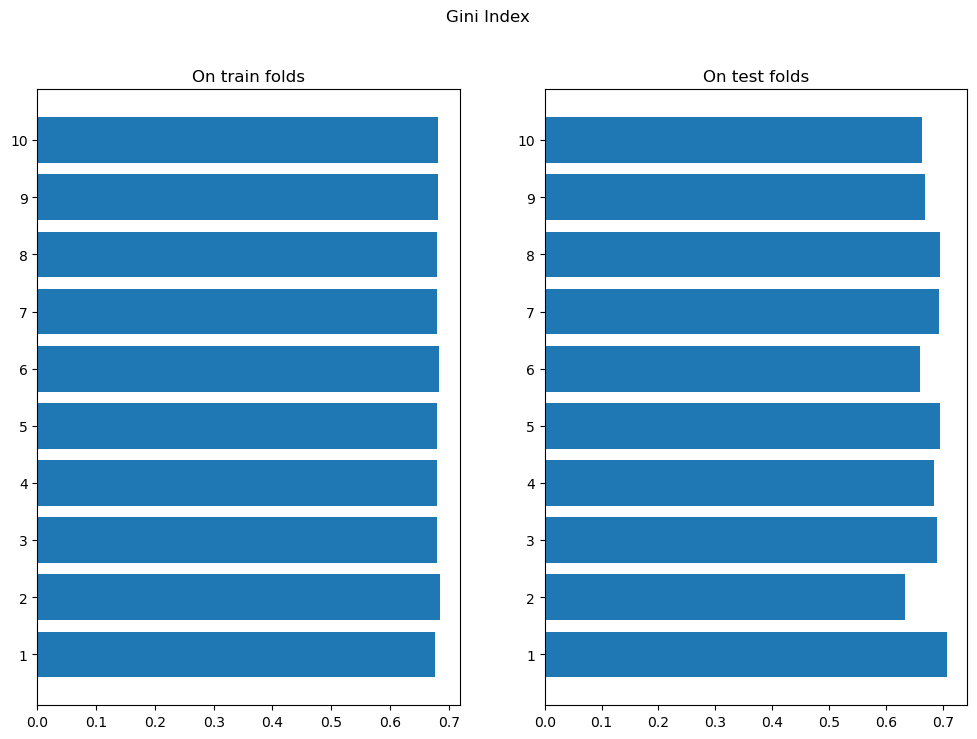

In [30]:
fig, ax = plt.subplots(1,2,figsize = (12, 8))

plt.suptitle('Gini Index')

ax[0].barh(y = [str(x) for x in range(1, len(kf_gini) + 1)], width = [x[0] for x in kf_gini])
ax[0].set_title('On train folds')

ax[1].barh(y = [str(x) for x in range(1, len(kf_gini) + 1)], width = [x[1] for x in kf_gini])
ax[1].set_title('On test folds')

In [31]:
# modelo
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.047468
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 Target   No. Observations:               297831
Model:                          Logit   Df Residuals:                   297811
Method:                           MLE   Df Model:                           19
Date:                Wed, 14 Feb 2024   Pseudo R-squ.:                  0.1638
Time:                        10:31:06   Log-Likelihood:                -14138.
converged:                       True   LL-Null:                       -16907.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -3.3877      0.108    -31.474      0.000      -3

> Primeiro modelo!! Como devemos interpretar esta informação: <br>

* **LL-Null:** Quanto mais alto melhor corresponde ao  F-statistic da regressao linear;<br>
** *LLR p-value:** Valor inferiore a 0.05 e podemos rejeitar a hipotese nula e por esse motivo podemos assumir o modelo como relevante. ou seja recusamos a hipotese de que o modelo é so constituido por Intercept e todos os coeficientes =0;<br>
* **Coef:** corresponde aos coeficientes, valor fixo atributido a cada Beta (β);<br>
* **Std err:** Erro Padrão; <br>
* **Z (z test statistic):** valor do coeficiente dividio pelo Std err quanto mais baixo melhor;<br>
* **P>|z|:** Corresponde ao p-value em relação a coluna z. Se o valor é inferior a uma determinada significacia (p.ex: 0.05) demostra uma relação e estatistica entre a variavel preditora e prevista, ou seja entre a Target e a variavel que a explica.<br>

> Assim como podem verifica neste modelo não temos p-values > 0.05, no entanto se tivessemos como deviamos agir? <br>

> A nossa sugestão é que não se submentam a "tirania" dos p-values, testem e avaliem comportamentos, há sempre a possibilidade de manter as variáveis porque o p-values não é assim tão elevado ou mesmo de pensar em alterar ou substituir por outra variável. Não há um resposta certa para estas situações testar e avaliar é sempre um boa forma de avançar.<br>

* **Coef:** quem é mais propenso a reagir a campanha?

> Quanto mais elevada as seguintes variaveis mais reagem. Na logistica procuramos prever o valor =1 ou seja a parte direita da curva S
> Os coeficientes com valores positivos impactam a deslocação na direcção da direita da curva S enquanto que os negativos impactam para a esquerda da curva S 

> Assim:
  * iClienteRevolving             
  * Max_NumDependentes                
  * iClientePCD                       

> Com valores positivos alto mostram ser caracteristicas que aumentam a probabilidade de resposta a uma campanha.

> Avaliação do Modelo

> Agora que temos um modelo que satisfaz as premissas estatisticas, precisamos de o avaliar. <br> As métricas que são usadas para avaliar um modelo devem estar relacionadas com o que o modelo pretende prever. <br> 
> Aqui o que nós queremos é ter um modelo que nos indique que é mais propenso a responder a uma campanha. <br> 
> O modelo irá dar-nos uma probabilidade e com base nessa probabilidade decidiremos que vamos contactar.<br> 
> Como pretendemos saber até que ponto o nosso modelo ordena corretamente estes clientes iremos usar a métrica de GINI para o avaliar. <br>

In [32]:
# uma das métricas mais tradicionais para avaliar um modelo é o GINI index
# Performance do modelo

pred_train = model.predict(X_train)
pred_valid = model.predict(X_valid)

gini_train = 2*roc_auc_score(y_train, pred_train) - 1
gini_valid = 2*roc_auc_score(y_valid, pred_valid) - 1

print("Model performance:\n\
    Training: %0.4f\n\
    Validation: %0.4f"%(gini_train, gini_valid))

Model performance:
    Training: 0.6807
    Validation: 0.6655


> Vamos lá usar o nosso modelo <br>
> Agora que treinamos o modelo podemos usá-lo para calcular probabilidades para os nossos dataset, treino, teste e fora de tempo.

>  Calcular probabilidade para todo o Dataset

In [33]:
# criar uma variável de para amostra de treino e validação
df_model['amostra'] = np.where(df_model['DtCampanha'] <= 20211031,'Treino', 'Valid')

# recolher dados necessário para calcular o nosso score
X_final, y_final, amostra = df_model[[x for x in model_variables]].copy(), df_model['Target'].copy(), df_model['amostra'].copy()

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, crc_debt_position)
    ], remainder = 'passthrough'
)

Xt_final = pd.DataFrame(preprocessor.fit_transform(df_model[model_variables]),\
                  columns = get_column_names(preprocessor, model_variables))

Xt_final.insert(0, 'Intercept', np.ones(len(df_model)))

#calcular score e criar o dataset para analise seguintes
score = pd.concat([Xt_final, y_final, amostra], axis = 1)
score['PredProba'] = model.predict(Xt_final)
score['PredScore'] = score['PredProba'].apply(lambda x: np.log(x/(1-x)))

> Avaliar a Distribuição 

In [34]:
treino  = score[(score['amostra'] == 'Treino')];
valid   = score[(score['amostra'] == 'Valid')];

# Specify the number of bins
num_bins = 10
el, bins = pd.qcut(treino['PredProba'], q=num_bins, retbins=True)

# Calculate deciles for XGBoost predictions
treino['decil'] = pd.cut(treino['PredProba'], bins=bins, labels=False) + 1
valid['decil']  = pd.cut(valid['PredProba'],  bins=bins, labels=False) + 1

treino = treino.groupby('decil')['Target'].agg(['count', 'mean']);
valid = valid.groupby('decil')['Target'].agg(['count', 'mean']);


C:\Users\SILVABU\AppData\Local\Temp\ipykernel_15636\1522613577.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treino['decil'] = pd.cut(treino['PredProba'], bins=bins, labels=False) + 1
C:\Users\SILVABU\AppData\Local\Temp\ipykernel_15636\1522613577.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['decil']  = pd.cut(valid['PredProba'],  bins=bins, labels=False) + 1


Text(0, 0.5, 'Taxa de Resposta')

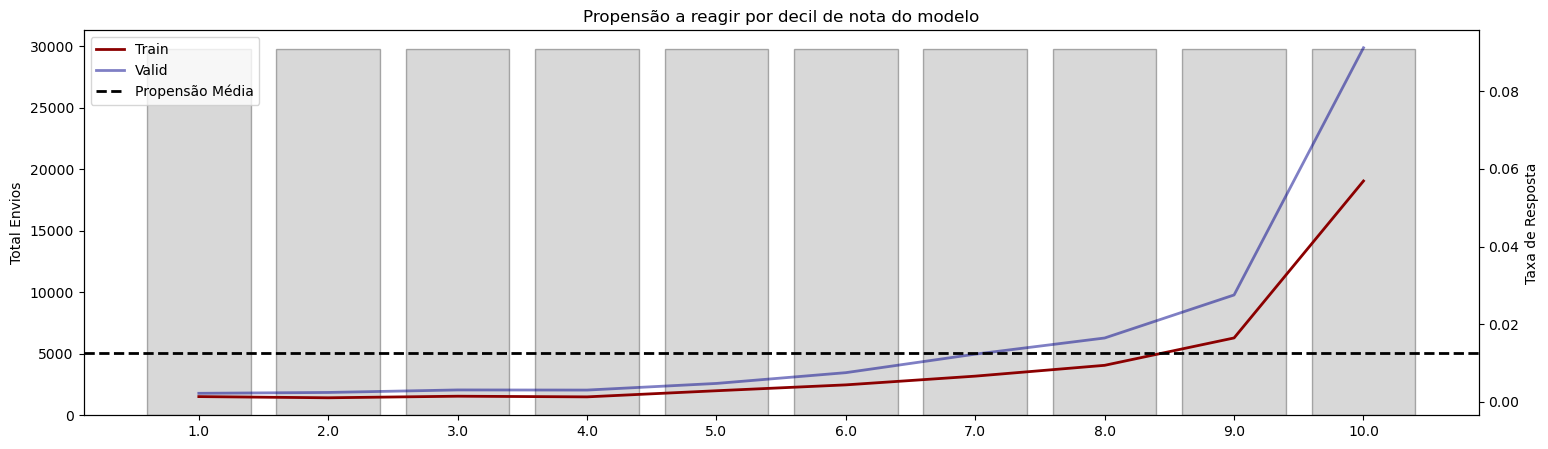

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
ax.bar(x=treino.index.astype('str'), height=treino['count'], color='grey', alpha=0.3, edgecolor='k')

axt = ax.twinx()

# Reindex lift_xgboost_oot to align with other samples
valid = valid.reindex(treino.index)

axt.plot(treino.index.astype('str'), treino['mean'], color='darkred', linewidth=2, label='Train')
axt.plot(valid.index.astype('str'), valid['mean'], color='darkblue', linewidth=2, label='Valid', alpha=0.5)

axt.axhline(y=score['Target'].mean(), linestyle='--', color='k', linewidth=2, label='Propensão Média')

plt.legend(loc=0)
plt.title('Propensão a reagir por decil de nota do modelo')

ax.set_ylabel('Total Envios')
axt.set_ylabel('Taxa de Resposta')

> O modelo criado mostra um boa capacidade de separação dos mais propensos e dos menos propensos, por exemplo o último decil mostra-nos uma propensão de resposta 7x superior ao valor médio observado. <br>

> Assim o nosso modelo parece estar a fazer um bom trabalho.<br>

___
# Aplicação do Modelo <a class="anchor" id="chapter9"></a>
> Este tipo de modelo propõem-se a ser um modelo de orientação que permite identificar os cliente que são mais propensos de responder a uma campanha. <br> 

> Isto ajuda na gestão de custos associados a geração de campanha e a aumentar a taxe de resposta das campanhas realizadas que passam a ser mais os clientes que respondem. <br>

> O Modelo foi implementado usado usando SQL visto que se trata de uma equação fechada é simples a sua implementação neste tipo de sistema/linguagem.

___
# Resumo <a class="anchor" id="chapter10"></a>

Neste projecto realizamos:
 * Exploração de dados
 * Implementação de uma regressão logistica
 * Aplicar o modelo treinado para obter resultados para toda a amostra
 * Definir pontos de corte em que podemos ter mais sucesso de envios
 * Como avaliar o sucesso do nosso modelo
